In [1]:
# Run this only once, run the next cell to verify that condalab was succesfully installed

!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
# Check if we are running this notebook on Kaggle, Google Colab or local compute resources.
import os
current_spot = os.getcwd()

if current_spot.startswith("/kaggle/working"):
    print("Kaggle says hi!")
    root_dir = "/kaggle/working"

elif current_spot.startswith("/content"):
    print("Google Colab says hi!")
    print(" NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.")
    root_dir = "/content"

else:
    msg = "You are using a behind-the-scenes resource. Follow our installation instructions here:"
    msg += " https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation"
    print(msg)
    root_dir = ""  # overwrite to set the root directory, where the data, checkpoints, and all relevant stuff will be stored


Google Colab says hi!
 NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.


In [3]:
# Install `micro-sam` from `conda-forge`.
!mamba install -y -q -c conda-forge micro_sam > /dev/null 2>&1
!pip uninstall -y --quiet napari  # GUI backends are not supported in Kaggle / Google Colab, let's remove it to avoid errors.
!pip install tifffile

In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
from PIL import Image
from glob import glob
from IPython.display import FileLink
from typing import Union, Tuple, Optional

import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components

import torch

from torch_em.util.debug import check_loader
from torch_em.data import MinInstanceSampler
from torch_em.util.util import get_random_colors
import tifffile
from skimage import io

import micro_sam.training as sam_training
# from micro_sam.sample_data import fetch_tracking_example_data, fetch_tracking_segmentation_data
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

In [7]:
# %%
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!nvidia-smi

#%%
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda if torch.cuda.is_available() else '不可用'}")
print(f"GPU count: {torch.cuda.device_count()}")

Sat May 24 02:46:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [8]:
# %%
torch.cuda.is_available()

True

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# %%
our_img = io.imread('/content/drive/MyDrive/Raw/combined_Images.tif')

out_img_uint8 = []

for i, page in enumerate(our_img):
    norm_page = (page - page.min()) / (page.max() - page.min())
    page_uint8 = (norm_page * 255).astype(np.uint8)
    out_img_uint8.append(page_uint8)

out_img_uint8 = np.array(out_img_uint8)
our_img = out_img_uint8

# Define the cropping boundaries
x_start, x_end = 0, 256
y_start, y_end = 0, 256
# z_start, z_end = 0, 100
cropped_our_img = our_img[:, y_start:y_end, x_start:x_end]

#split into 4 part
x_start1, x_end1 = 0, 128
x_start2, x_end2 = 128, 256
y_start1, y_end1 = 0, 128
y_start2, y_end2 = 128, 256
cropped_our_img1 = cropped_our_img[:, y_start1:y_end1, x_start1:x_end1]
cropped_our_img2 = cropped_our_img[:, y_start2:y_end2, x_start1:x_end1]
cropped_our_img3 = cropped_our_img[:, y_start1:y_end1, x_start2:x_end2]
cropped_our_img4 = cropped_our_img[:, y_start2:y_end2, x_start2:x_end2]

# data = np.array(cropped_our_img)
data = np.concatenate((cropped_our_img1, cropped_our_img2, cropped_our_img3, cropped_our_img4), axis=0)
tifffile.imwrite('output.tif', data)
tifffile.imwrite('cropped_our_img4.tif', cropped_our_img4)

print(data.min())
print(data.max())



0
255


In [12]:
def split_tiff_npz(input_tiff, input_npz, output_folder):
    # os.makedirs(output_folder, exist_ok=True)

    saved = 0
    os.makedirs(os.path.join(output_folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'masks'), exist_ok=True)

    # #when mask size= 260, 512, 512
    # mask = np.load(input_npz)['arr_0']
    # x_start, x_end = 256, 512
    # y_start, y_end = 256, 512
    # z_start, z_end = 100, 200
    # mask_input = mask[z_start:z_end, y_start:y_end, x_start:x_end]

    # when mask size= 100, 256, 256
    mask_input = np.load(input_npz)['arr_0']
    print(mask_input.shape)
    mask_input = mask_input[:,:,:]

    #split into 4 part
    x_start1, x_end1 = 0, 128
    x_start2, x_end2 = 128, 256
    y_start1, y_end1 = 0, 128
    y_start2, y_end2 = 128, 256
    cropped_our_img1 = mask_input[:, y_start1:y_end1, x_start1:x_end1]
    cropped_our_img2 = mask_input[:, y_start2:y_end2, x_start1:x_end1]
    cropped_our_img3 = mask_input[:, y_start1:y_end1, x_start2:x_end2]
    cropped_our_img4 = mask_input[:, y_start2:y_end2, x_start2:x_end2]
    mask_data = np.concatenate((cropped_our_img1, cropped_our_img2, cropped_our_img3, cropped_our_img4), axis=0)

    img = Image.open(input_tiff)
    img_2 = tifffile.imread(input_tiff)
    num_frames = mask_data.shape[0]
    print(num_frames)
    print(img)
    print(img_2.shape)

    for i in range(num_frames):
        mask_img = Image.fromarray(mask_data[i])
        img.seek(i)
        # save a NumPy array to Tiff image

        image_arr = np.array(img)
        image_arr = (image_arr / image_arr.max() * 255).astype(np.uint8)
        img_cvt = Image.fromarray(image_arr)

        frame_path = os.path.join(output_folder, 'images', f'frame_{i:03d}.tif')
        mask_path = os.path.join(output_folder, 'masks', f'mask_{i:03d}.tif')

        if np.unique(mask_data[i]).shape[0] > 0:
            img_cvt.save(frame_path, format='TIFF')
            mask_img.save(mask_path, format='TIFF')
            saved += 1

    img.close()
    print(f'Saved: {saved}')

In [13]:
# Image and Mask splitting
input_tiff = 'output.tif'

input_npz = '/content/drive/MyDrive/Raw/combined_Masks.npz'
# input_npz = 's1 -alban.npz'
output_folder = '0916s3_ourdatasets_Jacob'
split_tiff_npz(input_tiff, input_npz, output_folder)

(303, 256, 256)
1212
<PIL.TiffImagePlugin.TiffImageFile image mode=L size=128x128 at 0x7C53B80DA850>
(1212, 128, 128)
Saved: 1212


In [14]:
# %%
image_dir = '0916s3_ourdatasets_Jacob/images'
segmentation_dir = '0916s3_ourdatasets_Jacob/masks'
root_dir = '0916s3_ourdatasets_Jacob'
print(root_dir)
print(image_dir)
print(segmentation_dir)

0916s3_ourdatasets_Jacob
0916s3_ourdatasets_Jacob/images
0916s3_ourdatasets_Jacob/masks


In [15]:
# %%
image_paths = sorted(glob(os.path.join(image_dir, "*")))
segmentation_paths = sorted(glob(os.path.join(segmentation_dir, "*")))

# It appears that the images are in tif format. It's a supported data format. Now let's check how the data looks.
image_shapes = [imageio.imread(path).shape for path in image_paths]
label_shapes = [imageio.imread(path).shape for path in segmentation_paths]
print(image_shapes, label_shapes)

[(128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (12

In [16]:
volume_paths = glob(os.path.join(image_dir, "*"))
print("The volume extension seems to be:", os.path.splitext(volume_paths[0])[-1])

The volume extension seems to be: .tif


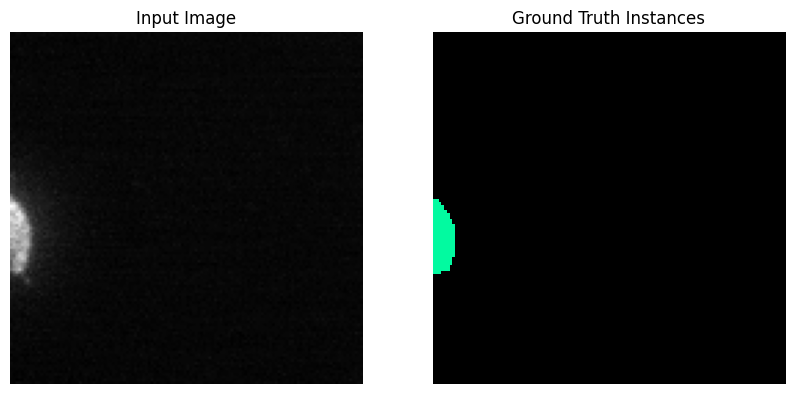

In [17]:
# %%
image_paths = sorted(glob(os.path.join(image_dir, "*")))
segmentation_paths = sorted(glob(os.path.join(segmentation_dir, "*")))

for image_path, segmentation_path in zip(image_paths, segmentation_paths):
    image = imageio.imread(image_path)
    segmentation = imageio.imread(segmentation_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    segmentation = connected_components(segmentation)
    ax[1].imshow(segmentation, cmap=get_random_colors(segmentation), interpolation="nearest")
    ax[1].set_title("Ground Truth Instances")
    ax[1].axis("off")

    plt.show()
    plt.close()

    break  # comment this out in case you want to visualize all the images

In [18]:
# These are the total number of images available
print(len(image_shapes))

# For 75% training split
print("split at:", int(len(image_shapes)-1/4*len(image_shapes)))

1212
split at: 909


In [19]:
# train validation split
raw_key, label_key = "*.tif", "*.tif"

# a=np.arange(1000)
# a = a.reshape(((10,10,10)))
# x=a[3:,:,:]

train_roi = np.s_[:909, :, :]
val_roi = np.s_[909:, :, :]

In [20]:
# %%
# The script below returns the train or val data loader for finetuning Segment Anything Model (SAM).
# The data loader must be a torch data loader that returns `x, y` tensors, where `x` is the image data and `y` are the labels.
# The labels have to be in a label mask instance segmentation format.
# i.e. a tensor of the same spatial shape as `x`, with each object mask having its own ID.
# Important: the ID 0 is reseved for background, and the IDs must be consecutive

# Here, we use `micro_sam.training.default_sam_loader` for creating a suitable data loader from
# the example hela data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here's a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

batch_size = 1  # the training batch size
patch_shape = (1, 128, 128)  # the size of patches for training

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
# NOTE 1: It's important to have densely annotated-labels while training the additional convolutional decoder.
# NOTE 2: In case you do not have labeled images, we recommend using `micro-sam` annotator tools to annotate as many objects as possible per image for best performance.
train_instance_segmentation = True

# NOTE: The dataloader internally takes care of adding label transforms: i.e. used to convert the ground-truth
# labels to the desired instances for finetuning Segment Anythhing, or, to learn the foreground and distances
# to the object centers and object boundaries for automatic segmentation.

# There are cases where our inputs are large and the labeled objects are not evenly distributed across the image.
# For this we use samplers, which ensure that valid inputs are chosen subjected to the paired labels.
# The sampler chosen below makes sure that the chosen inputs have atleast one foreground instance, and filters out small objects.
sampler = MinInstanceSampler(min_size=25)  # NOTE: The choice of 'min_size' value is paired with the same value in 'min_size' filter in 'label_transform'.

train_loader = sam_training.default_sam_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    rois=train_roi,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)

val_loader = sam_training.default_sam_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    rois=val_roi,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)


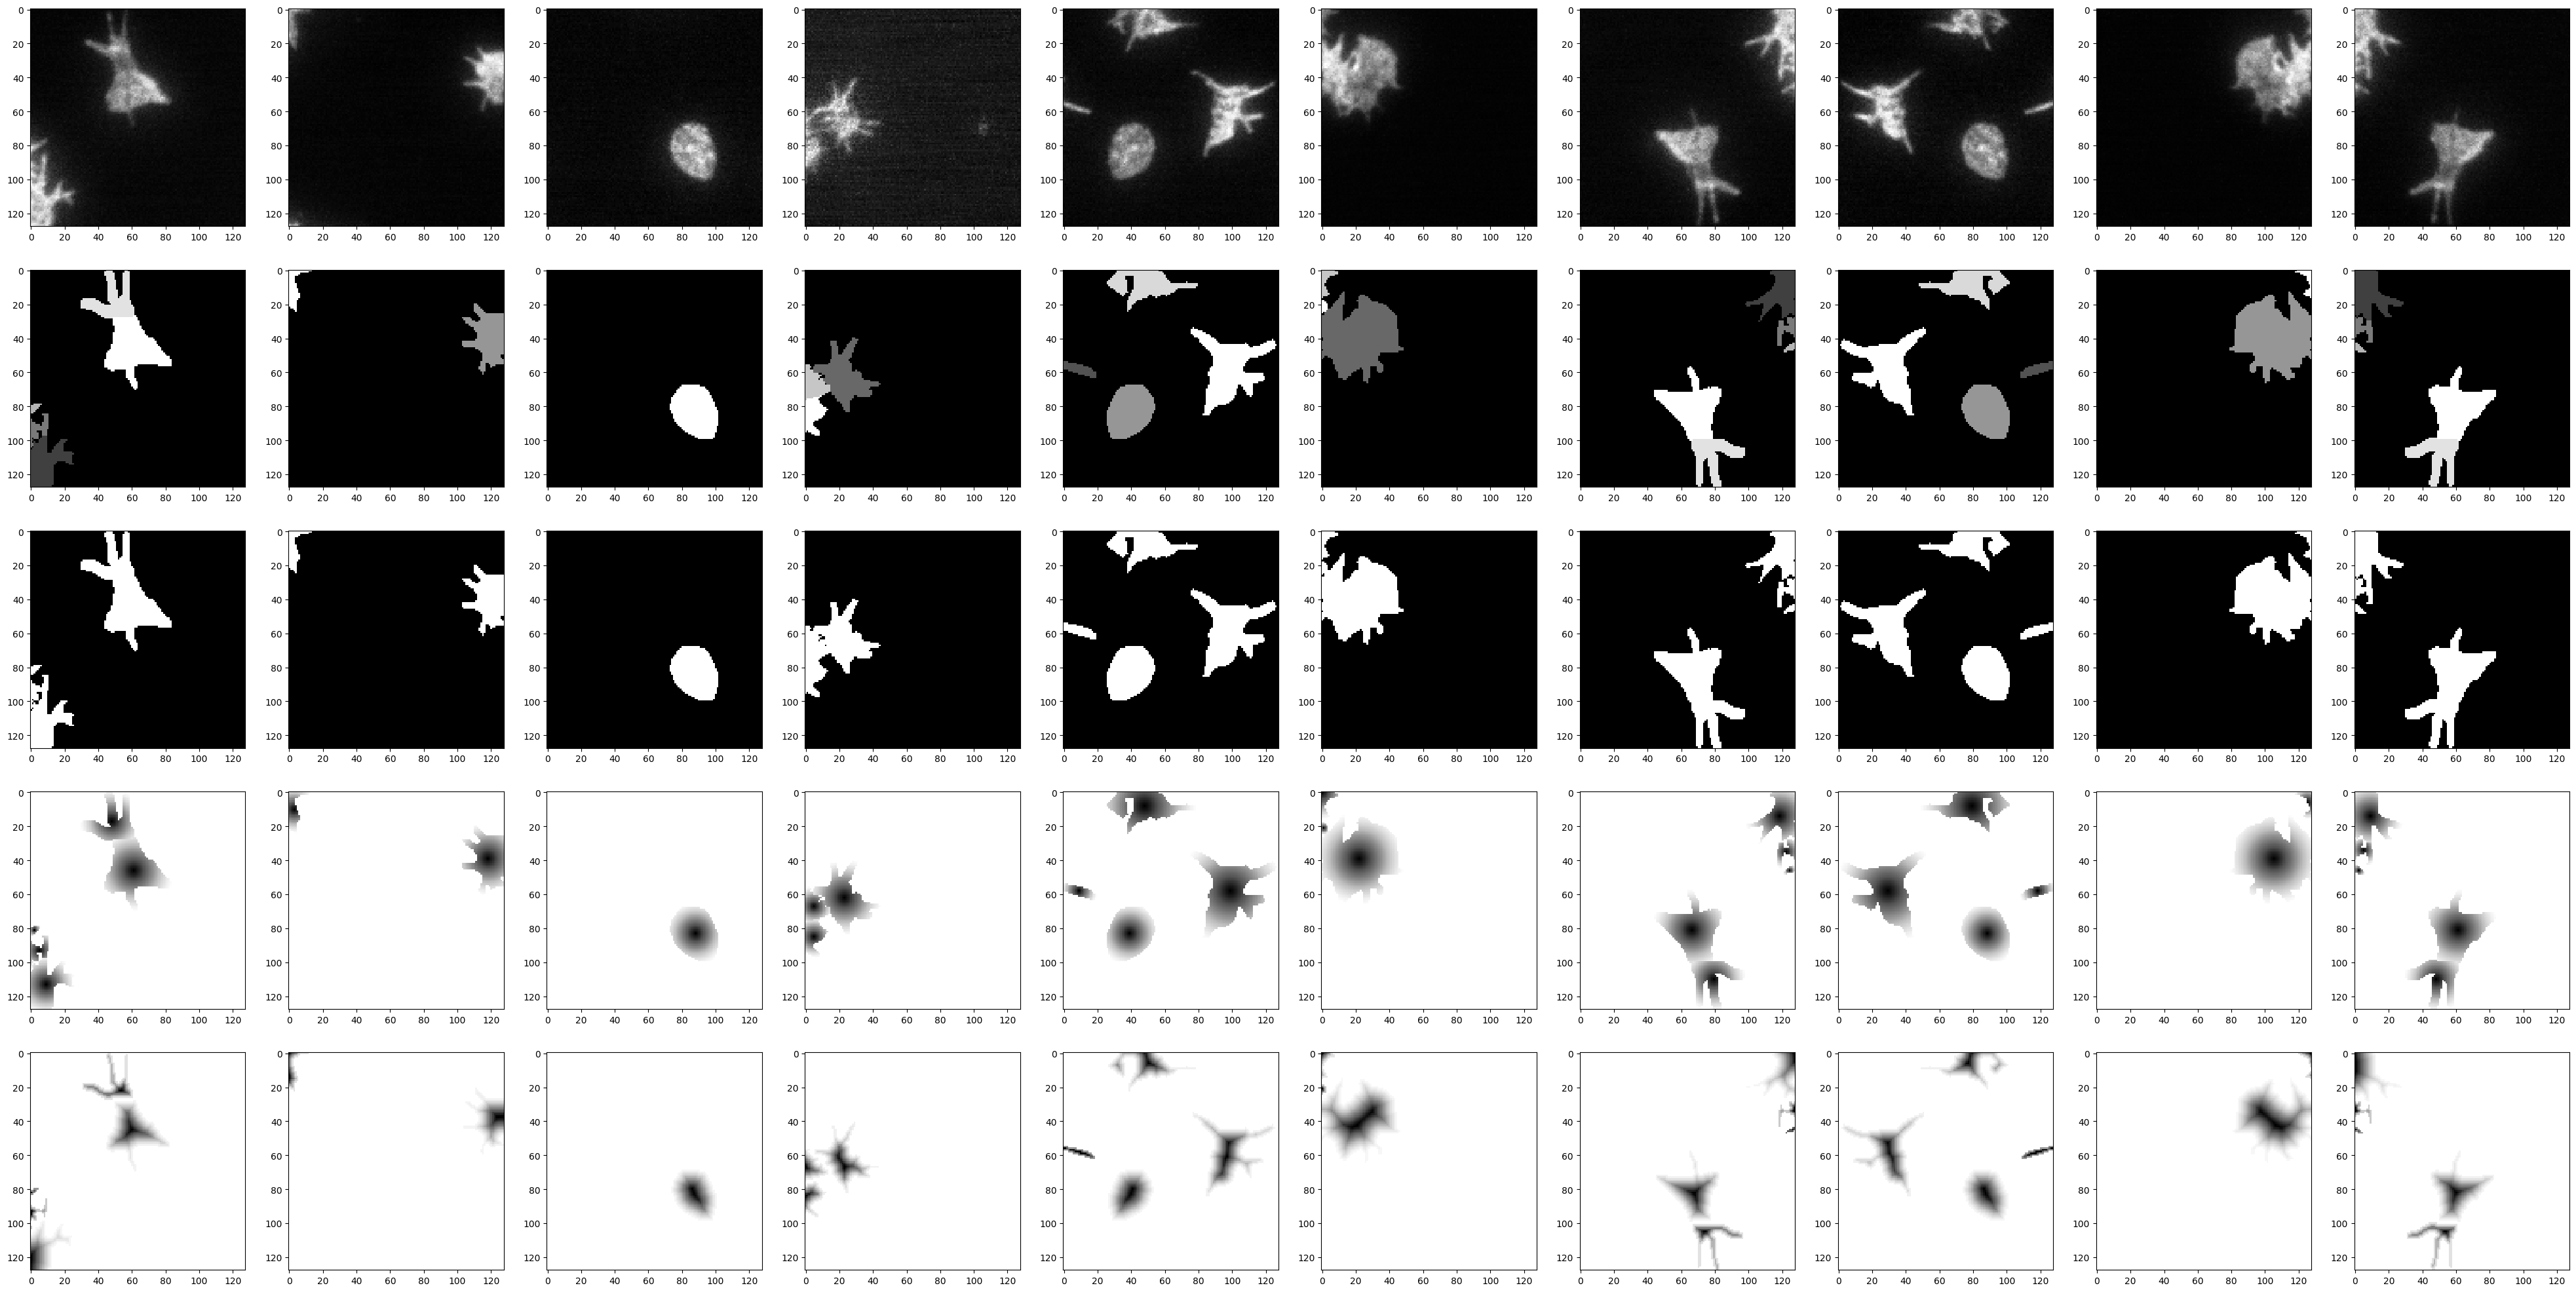

In [21]:
# %%
# Let's check how our samples look from the dataloader
check_loader(train_loader, 10, plt=True, rgb=True)

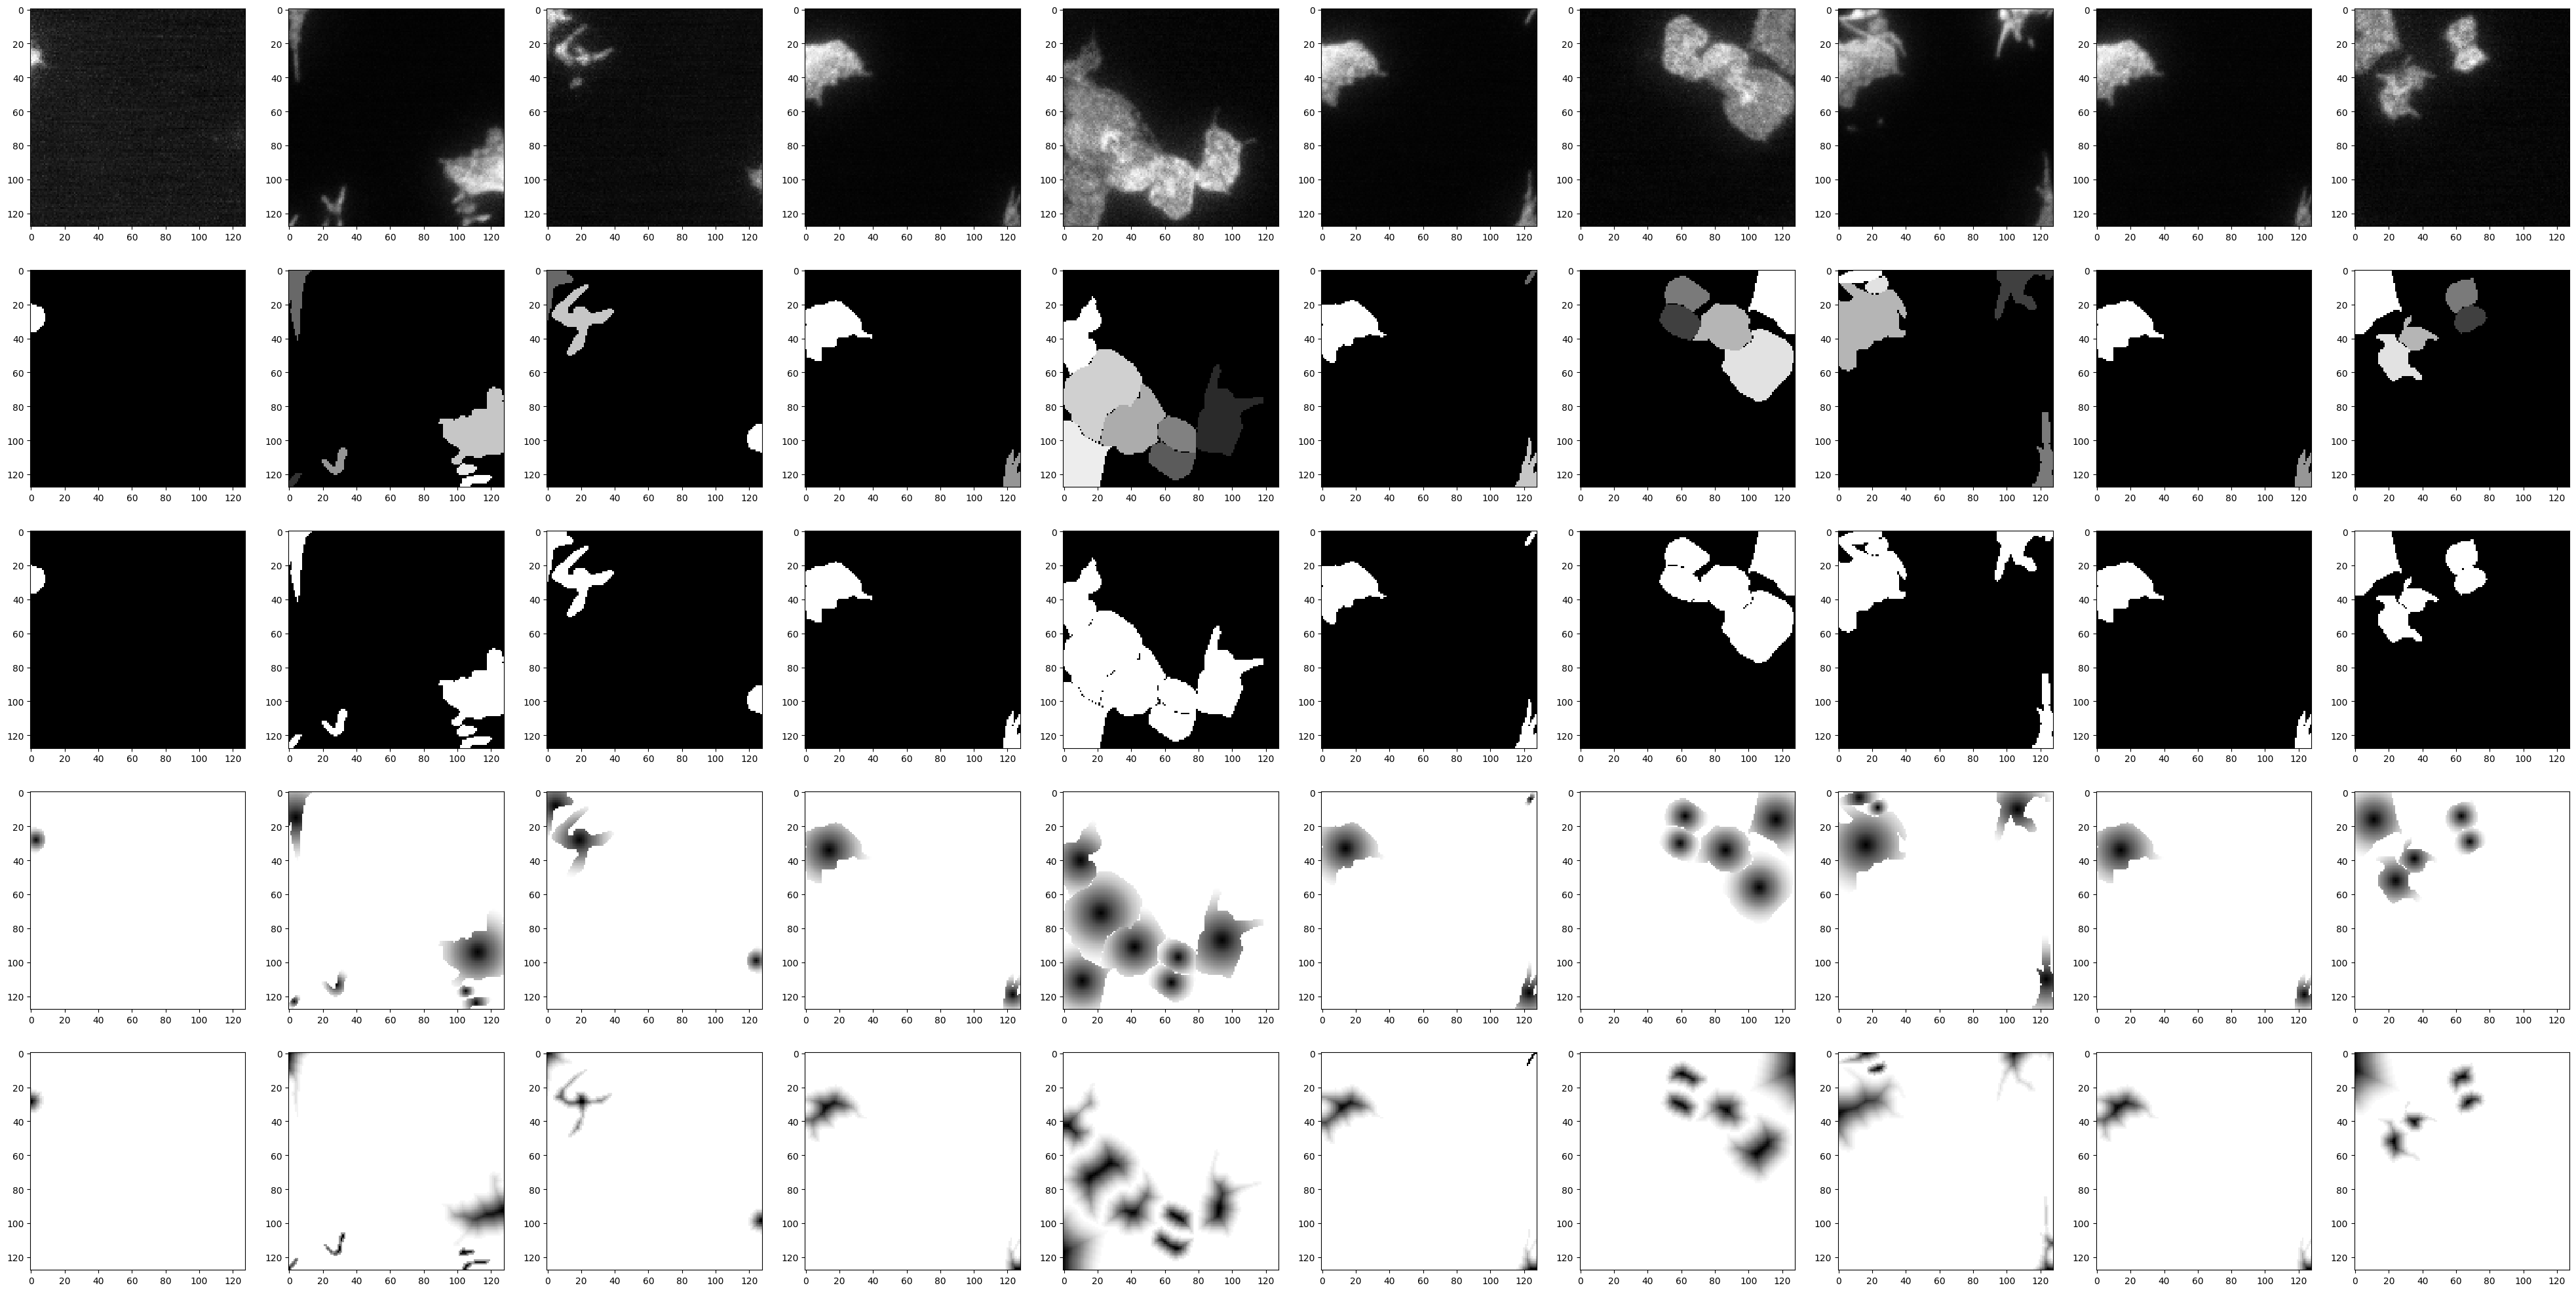

In [22]:
check_loader(val_loader, 10, plt=True, rgb=True)

In [23]:
# %%
# All hyperparameters for training.
n_objects_per_batch = 5  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 3  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_b_lm"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "model_Jacob"


In [24]:
# %%
# Run training
sam_training.train_sam(
    name=checkpoint_name,
    save_root=os.path.join(root_dir, "models"),
    model_type=model_type,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
)

Verifying labels in 'val' dataloader: 100%|██████████| 50/50 [00:00<00:00, 117.99it/s]
100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 542GB/s]
100%|█████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 75.8GB/s]


Start fitting for 2727 iterations /  3 epochs
with 909 iterations per epoch
Training with mixed precision


Epoch 3: average [s/it]: 0.518183, current metric: 0.160995, best metric: 0.160085: 100%|█████████▉| 2726/2727 [25:37<00:00,  1.93it/s]

Finished training after 3 epochs / 2727 iterations.
The best epoch is number 0.
Training took 1583.5833096504211 seconds (= 00:26:24 hours)


In [24]:
# %%
best_checkpoint = '0916s3_ourdatasets_Jacob/models/checkpoints/model_Jacob/best.pt'
# Download link is automatically generated for the best model.
print("Click here \u2193")
FileLink(best_checkpoint)


Click here ↓


/content/0916s3_ourdatasets_Jacob/models/checkpoints/model_Jacob/best.pt

In [25]:
fn = 'ourdatasets/cropped_our_img4'

preditor, segmenter = get_predictor_and_segmenter(
    model_type = "vit_b_lm",
    checkpoint='/content/0916s3_ourdatasets_Jacob/models/checkpoints/model_Jacob/best.pt',
    device='cuda'
)

result = automatic_instance_segmentation(
    predictor=preditor,
    segmenter=segmenter,
    input_path='cropped_our_img4.tif',
    output_path='cropped_our_img4_mask.tif'
)


# np.savez_compressed(f'{fn}.npz', result)

Merge segmentation: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


The automatic segmentation results are stored at '/content/cropped_our_img4_mask.tif'.


In [26]:
# %%
def run_automatic_instance_segmentation(
    image: np.ndarray,
    checkpoint_path: Union[os.PathLike ,str],
    model_type: str = "vit_b_lm",
    device: Optional[Union[str, torch.device]] = None,
    tile_shape: Optional[Tuple[int, int]] = None,
    halo: Optional[Tuple[int, int]] = None,
):
    """Automatic Instance Segmentation (AIS) by training an additional instance decoder in SAM.

    NOTE: AIS is supported only for `µsam` models.

    Args:
        image: The input image.
        checkpoint_path: The path to stored checkpoints.
        model_type: The choice of the `µsam` model.
        device: The device to run the model inference.
        tile_shape: The tile shape for tiling-based segmentation.
        halo: The overlap shape on each side per tile for stitching the segmented tiles.

    Returns:
        The instance segmentation.
    """
    # Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=model_type, # choice of the Segment Anything model
        checkpoint=checkpoint_path,  # overwrite to pass your own finetuned model.
        device=device,  # the device to run the model inference.
        is_tiled=(tile_shape is not None),  # whether to run automatic segmentation
    )

    # Step 2: Get the instance segmentation for the given image.
    prediction = automatic_instance_segmentation(
        predictor=predictor,  # the predictor for the Segment Anything model.
        segmenter=segmenter,  # the segmenter class responsible for generating predictions.
        input_path=image,  # the filepath to image or the input array for automatic segmentation.
        ndim=2,  # the number of input dimensions.
        tile_shape=tile_shape,  # the tile shape for tiling-based prediction.
        halo=halo,  # the overlap shape for tiling-based prediction.
    )

    return prediction


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 29.17it/s]


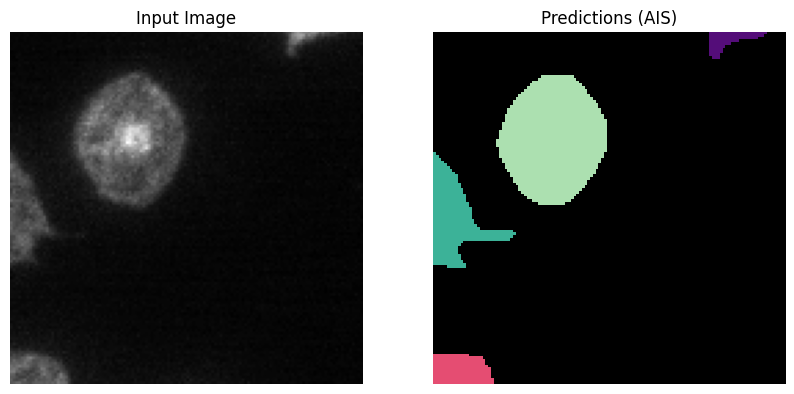

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s]


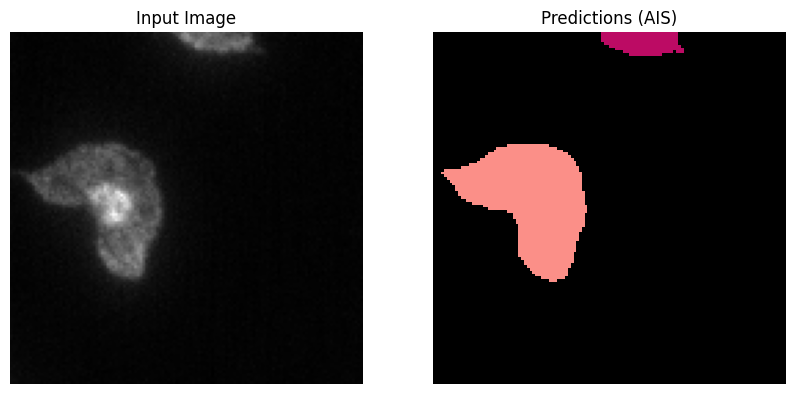

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.89it/s]


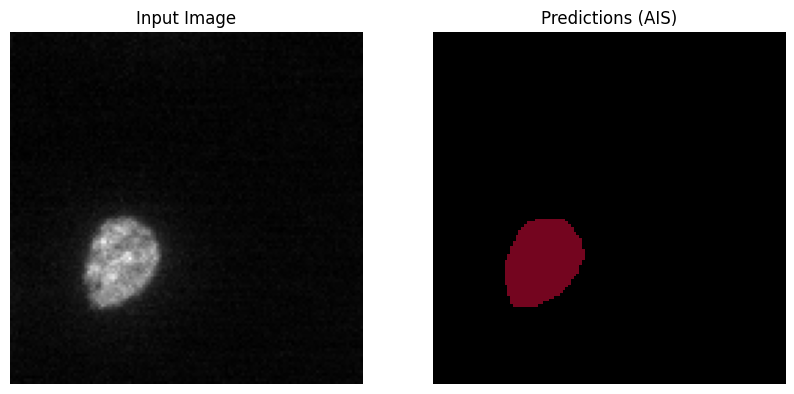

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.40it/s]


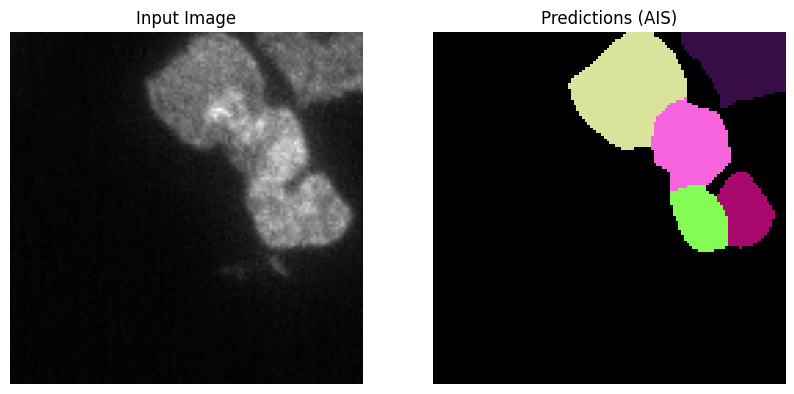

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s]


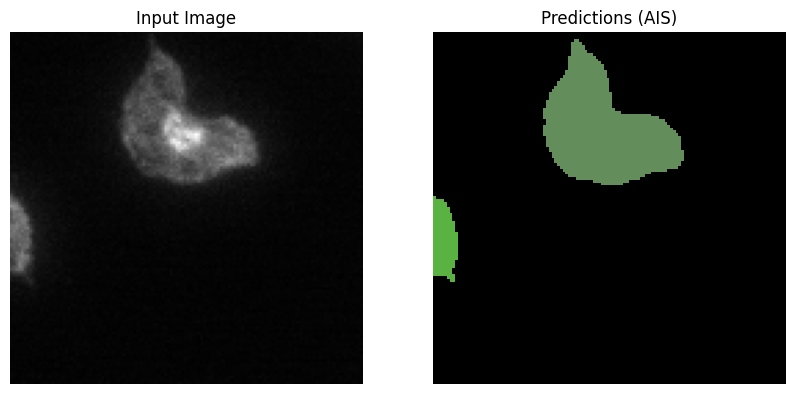

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 32.37it/s]


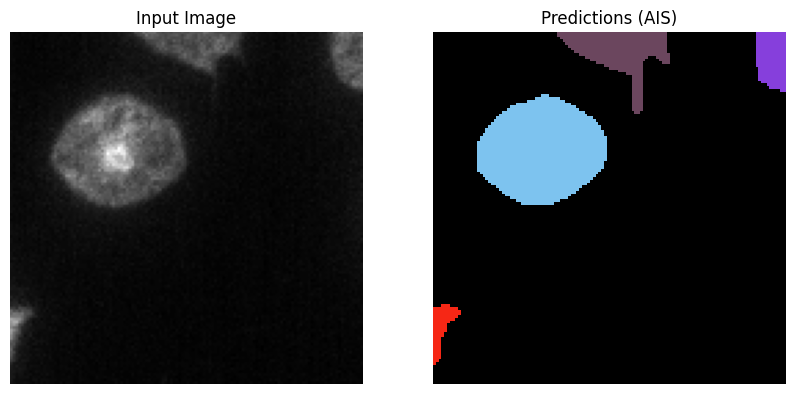

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.13it/s]


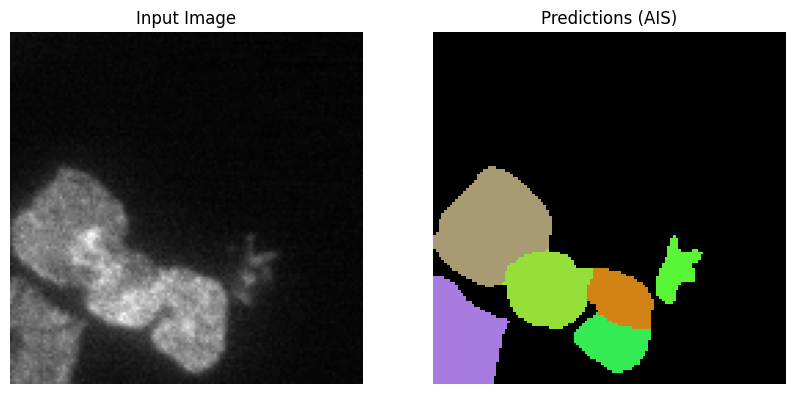

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.91it/s]


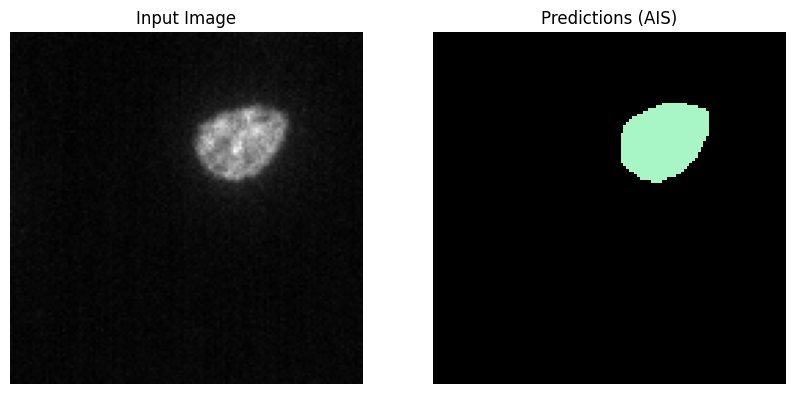

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.63it/s]


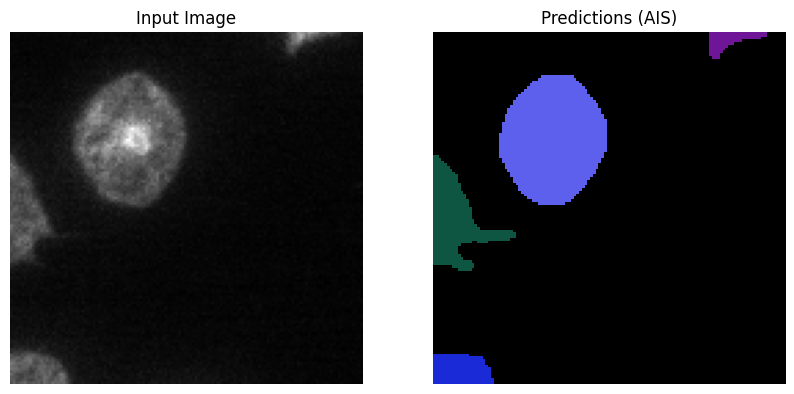

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 29.13it/s]


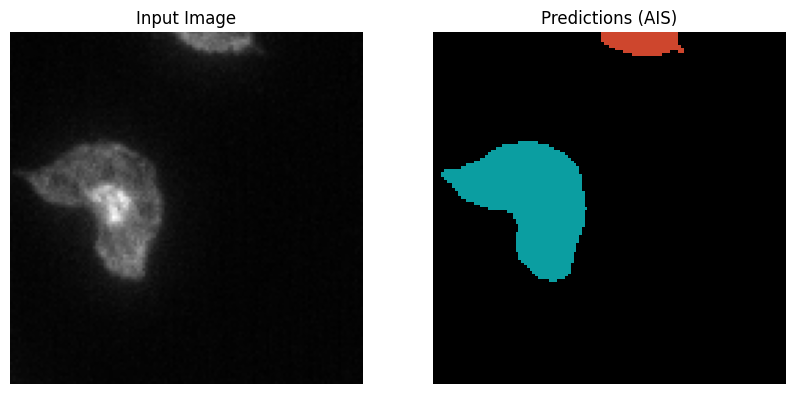

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 30.12it/s]


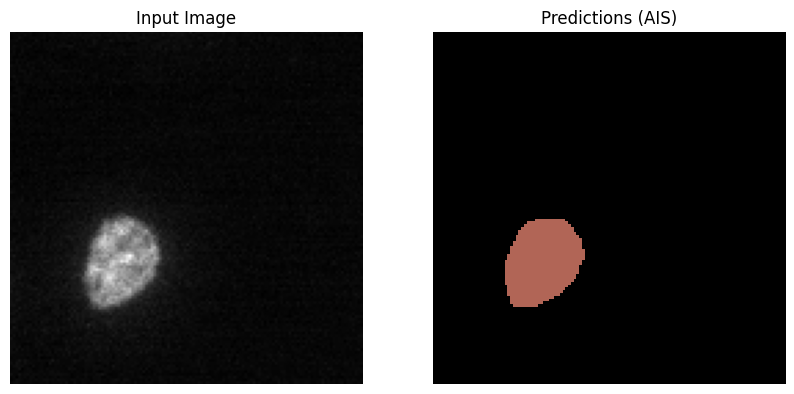

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.50it/s]


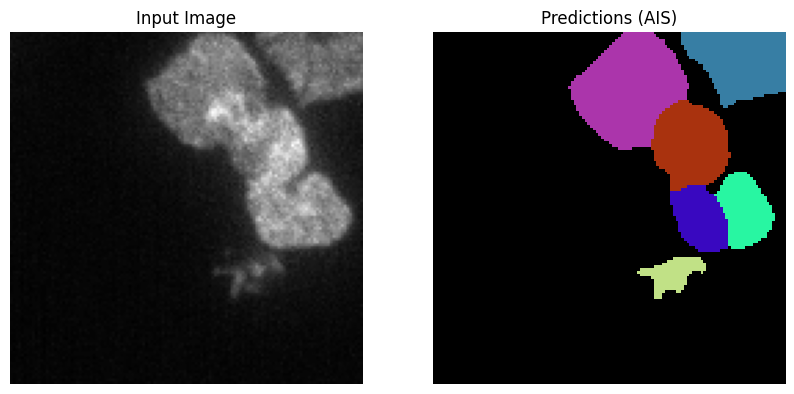

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 29.98it/s]


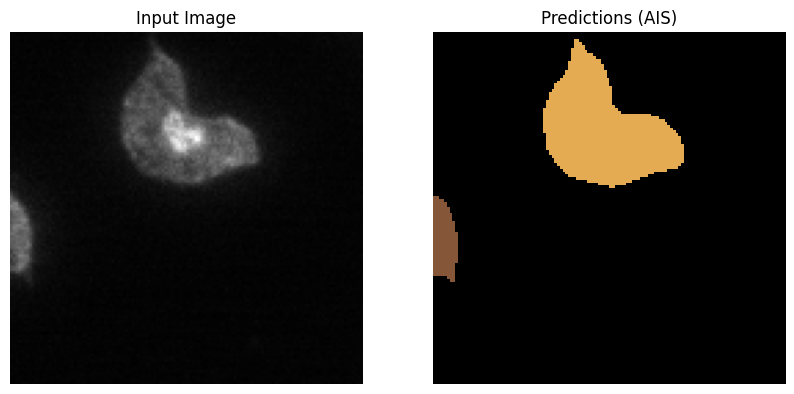

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.43it/s]


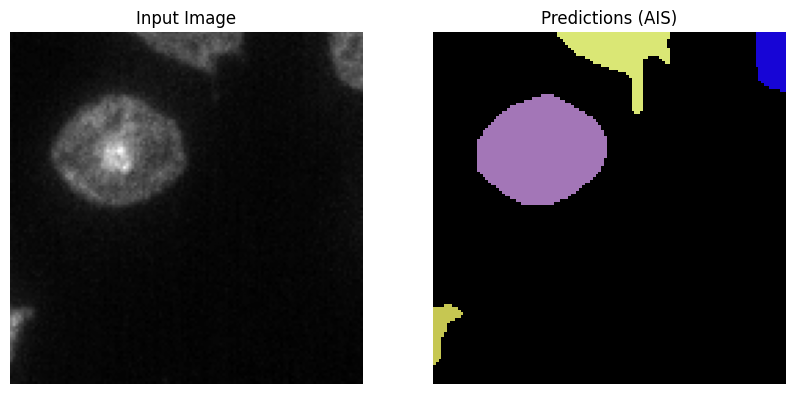

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s]


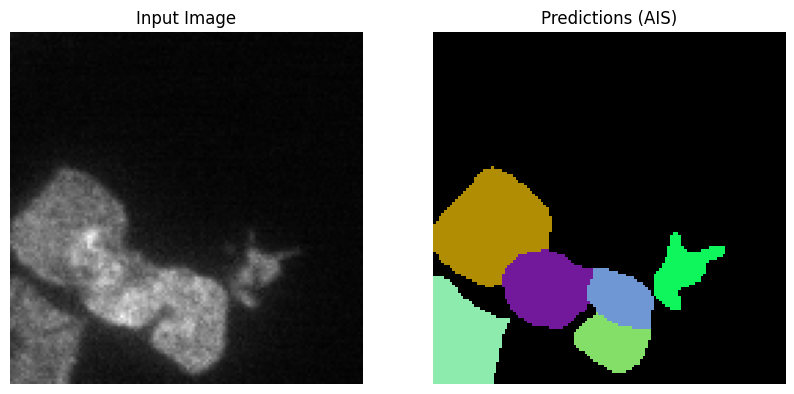

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 30.14it/s]


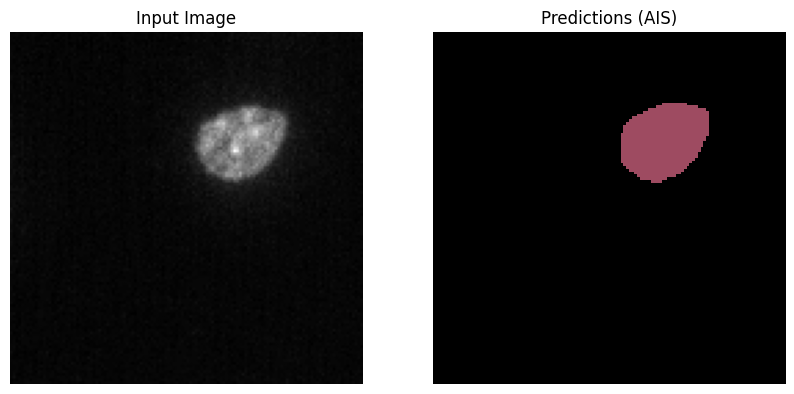

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


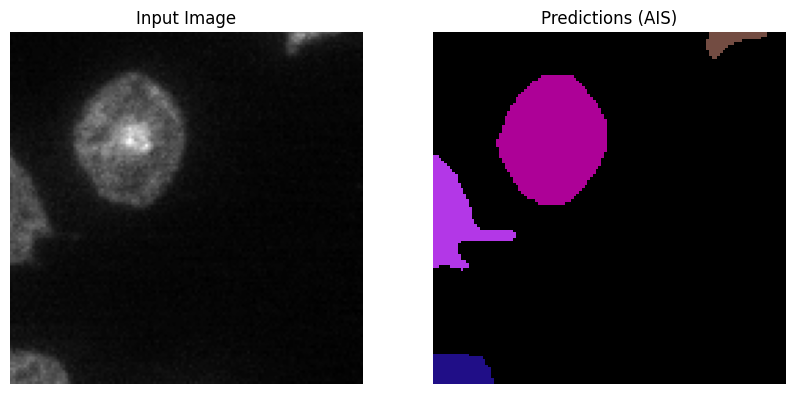

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 29.85it/s]


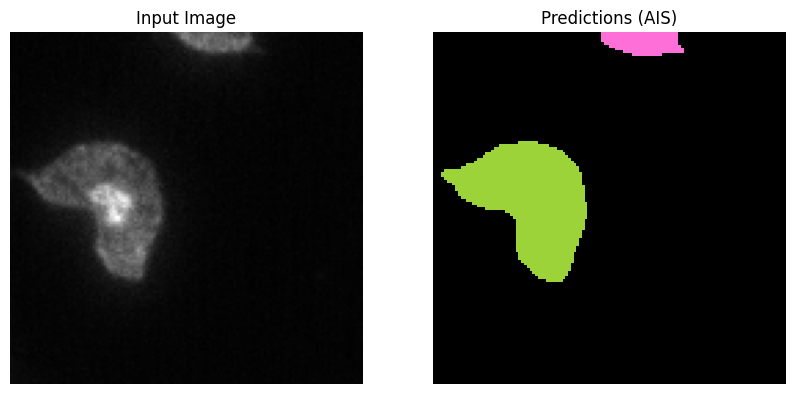

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.90it/s]


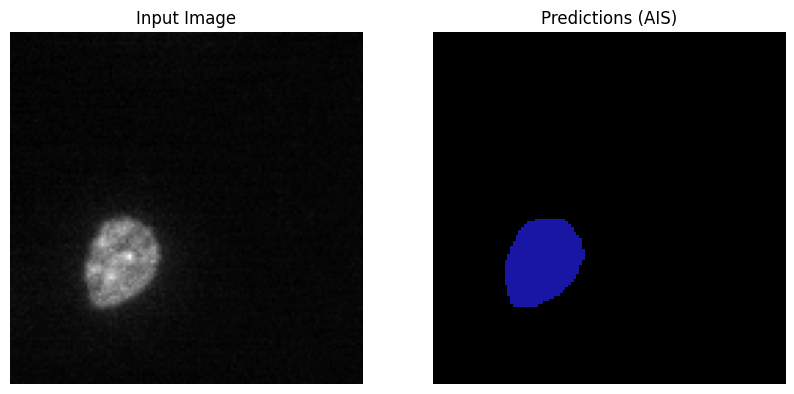

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 29.48it/s]


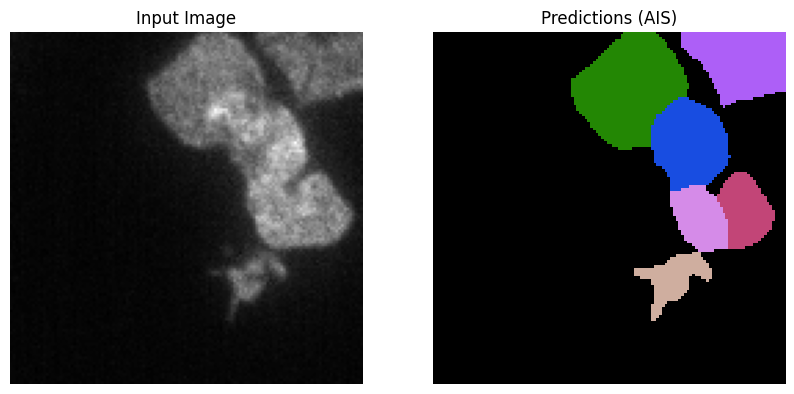

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.99it/s]


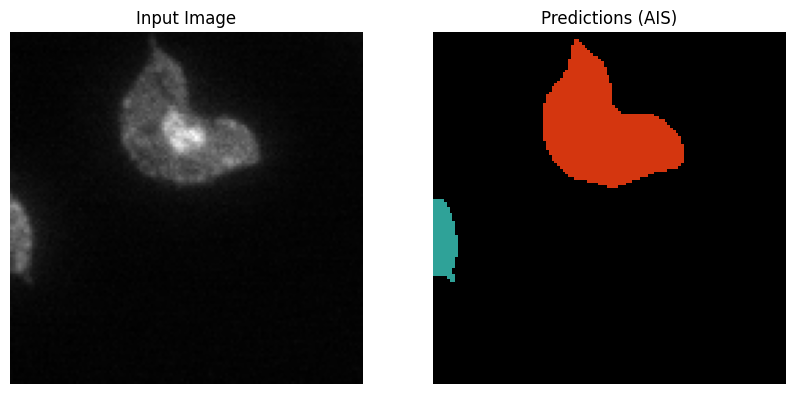

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 32.19it/s]


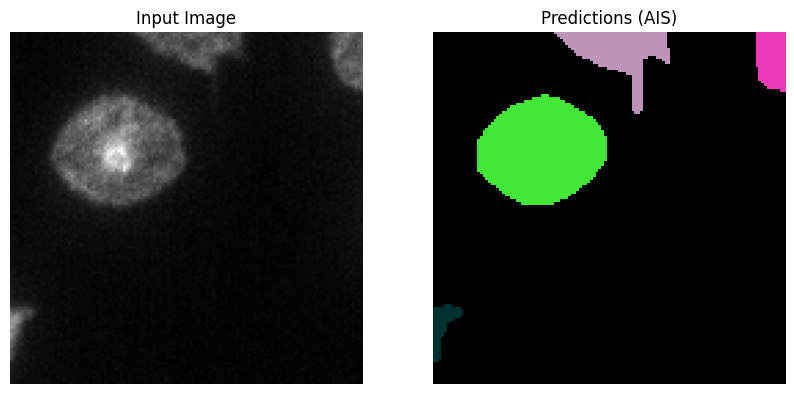

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 32.03it/s]


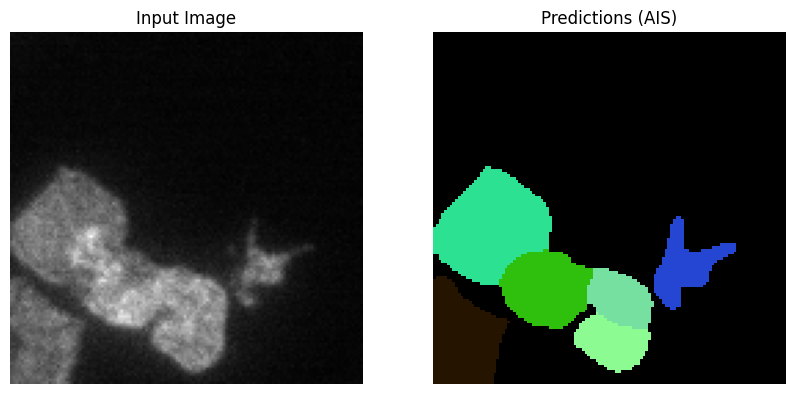

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.00it/s]


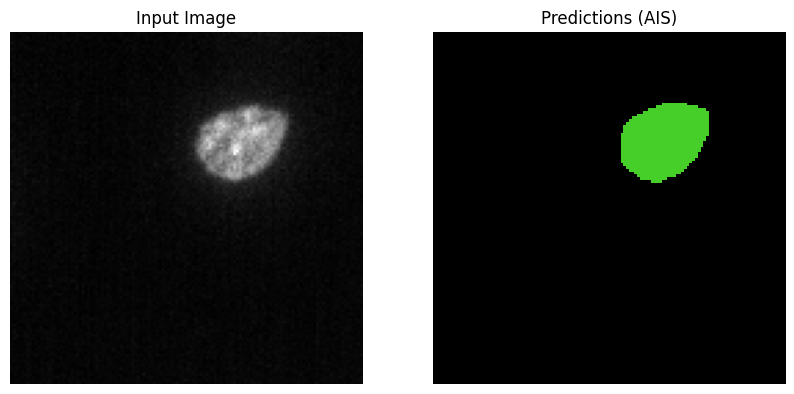

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 31.50it/s]


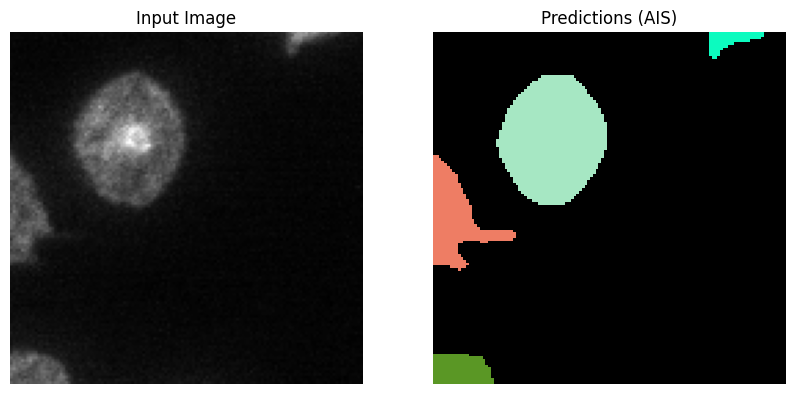

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.98it/s]


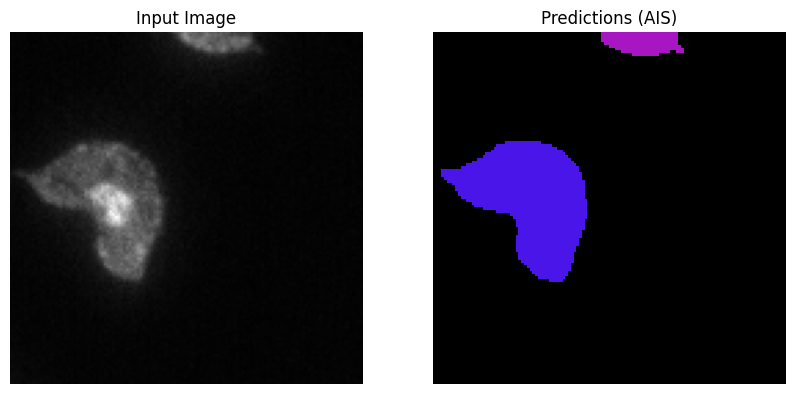

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.88it/s]


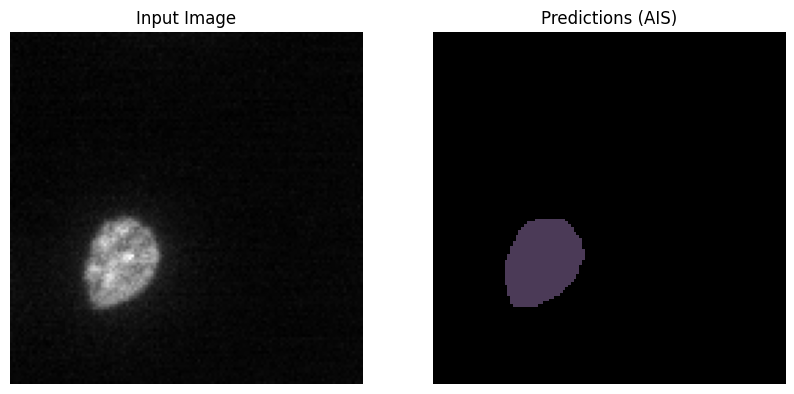

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.38it/s]


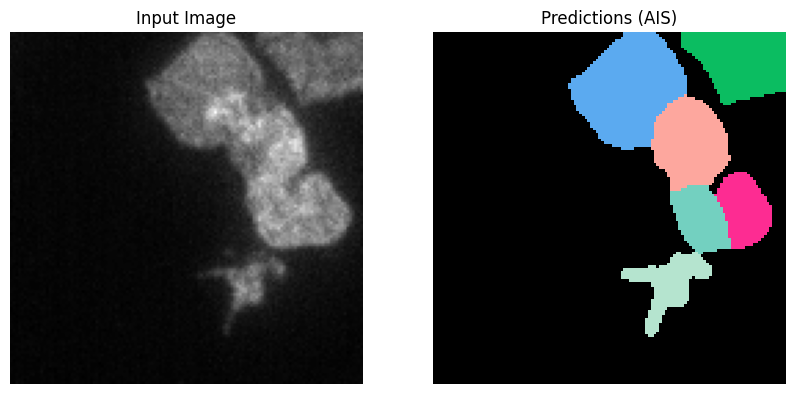

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 29.91it/s]


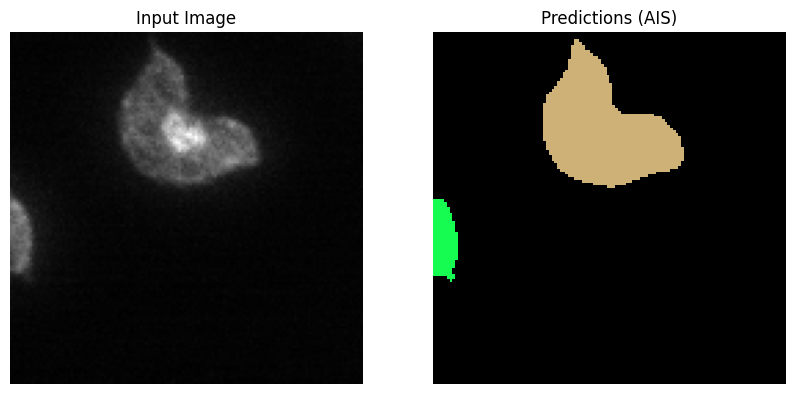

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]


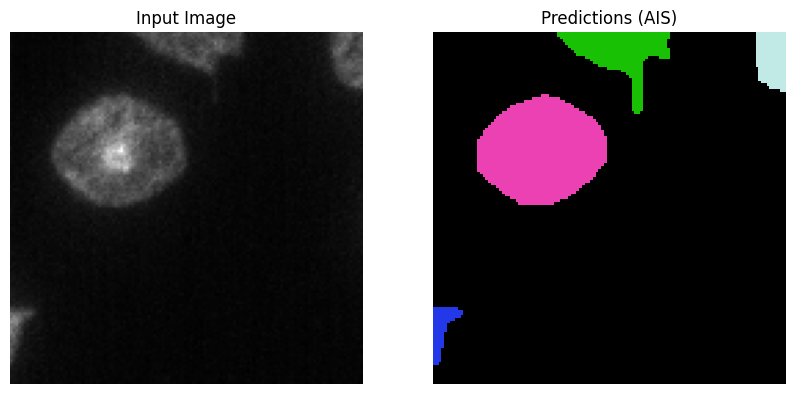

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 32.09it/s]


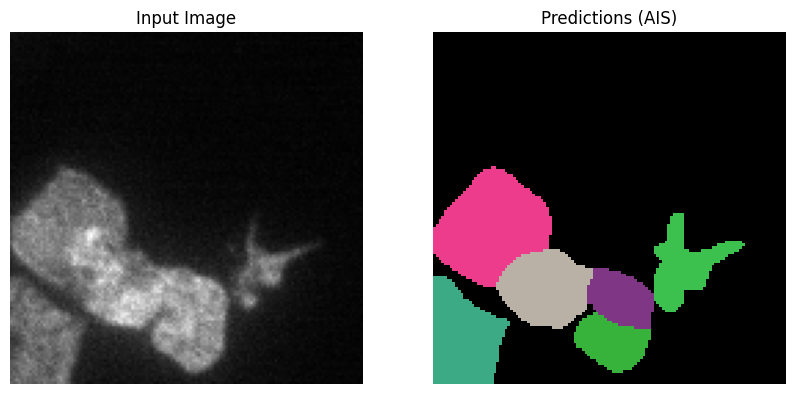

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s]


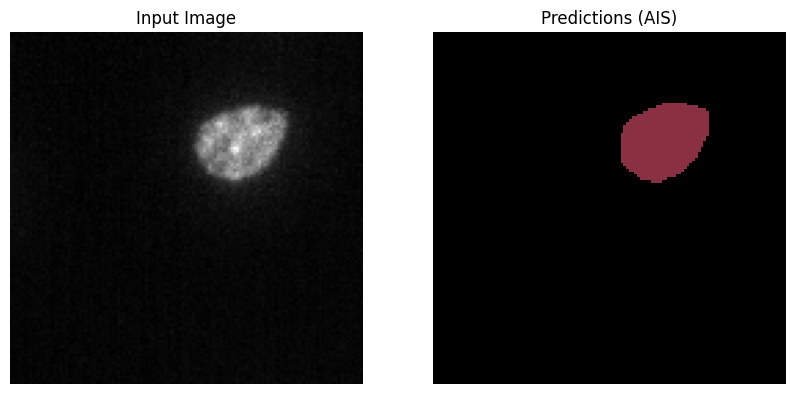

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]


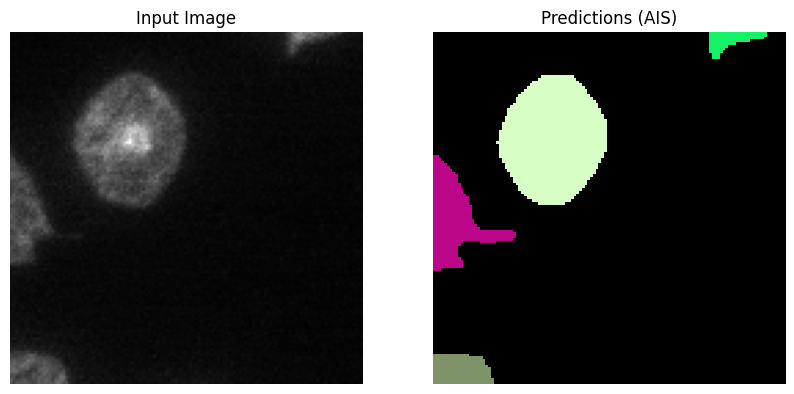

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.07it/s]


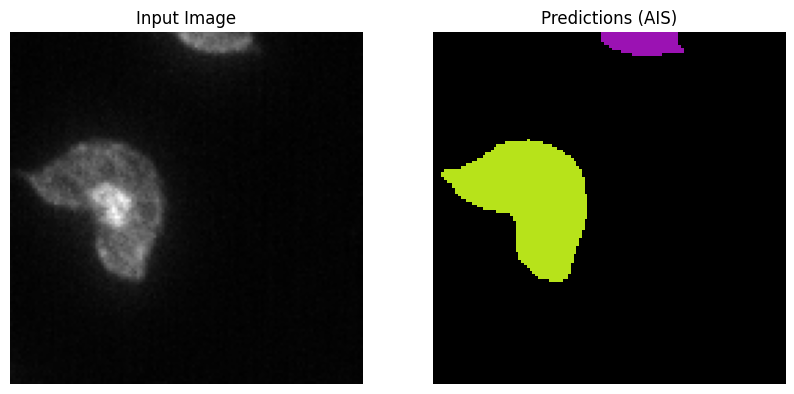

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 31.24it/s]


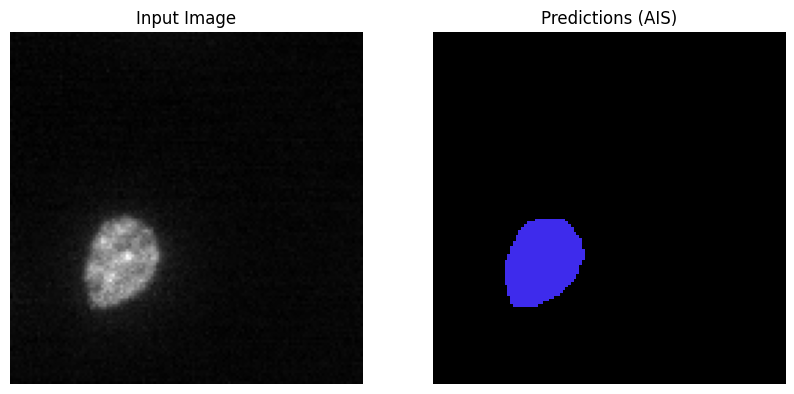

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.47it/s]


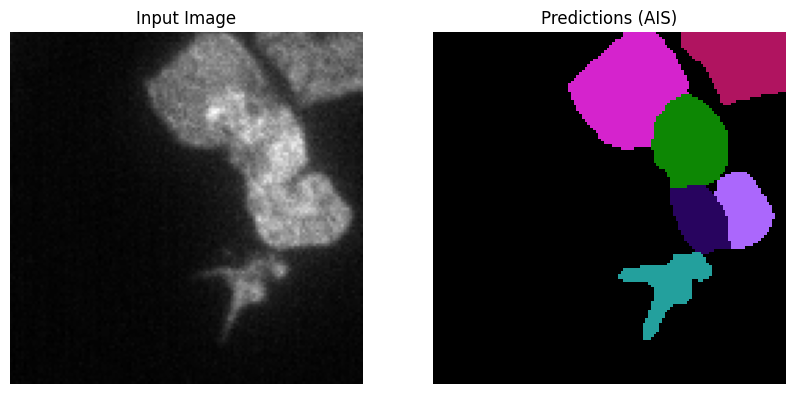

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.91it/s]


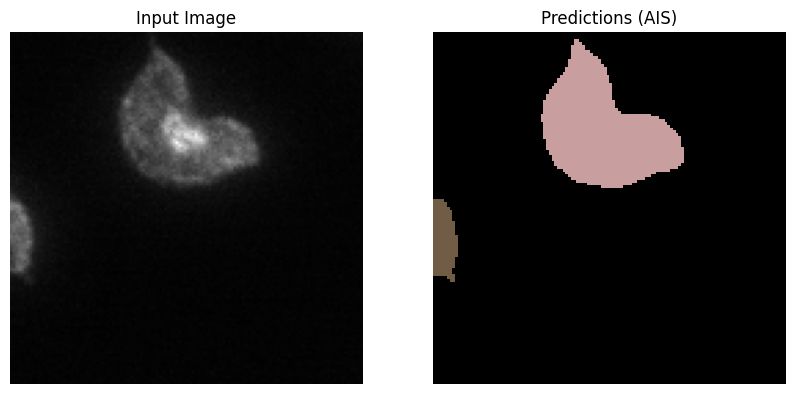

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.41it/s]


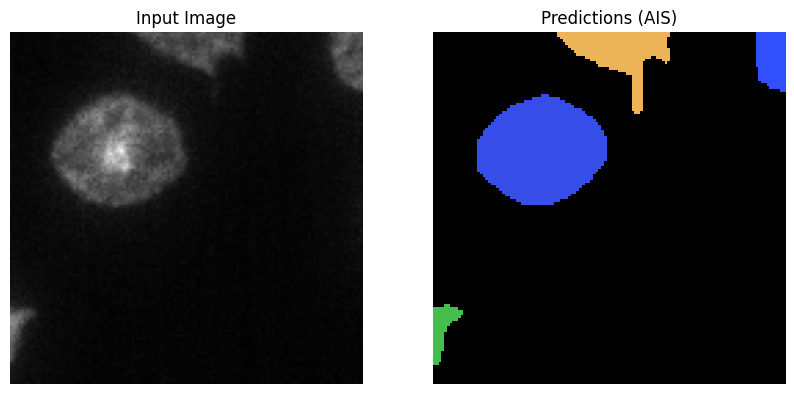

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 30.51it/s]


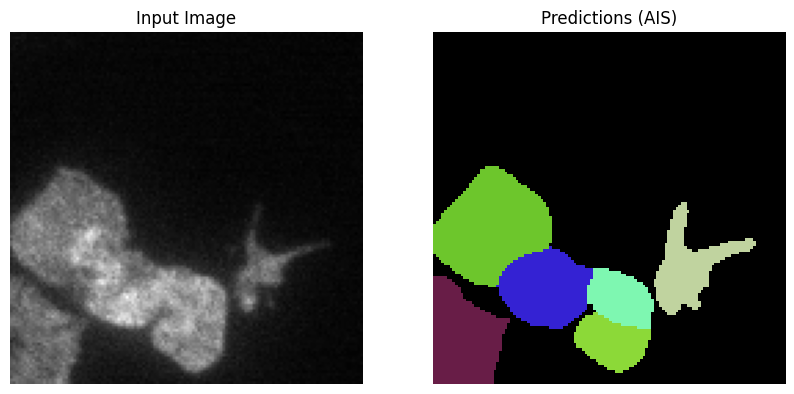

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


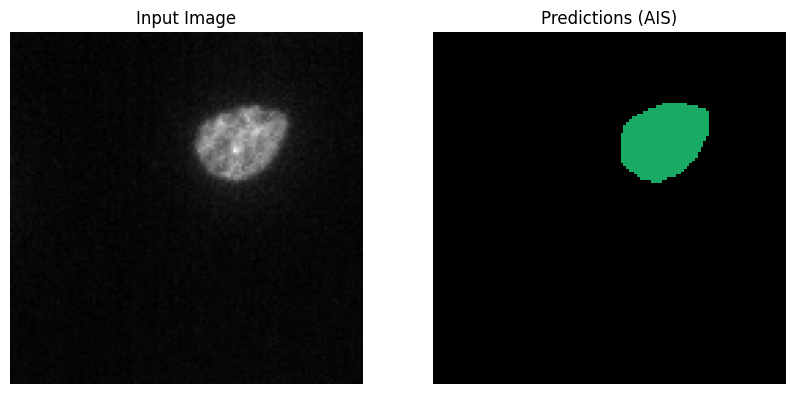

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 30.41it/s]


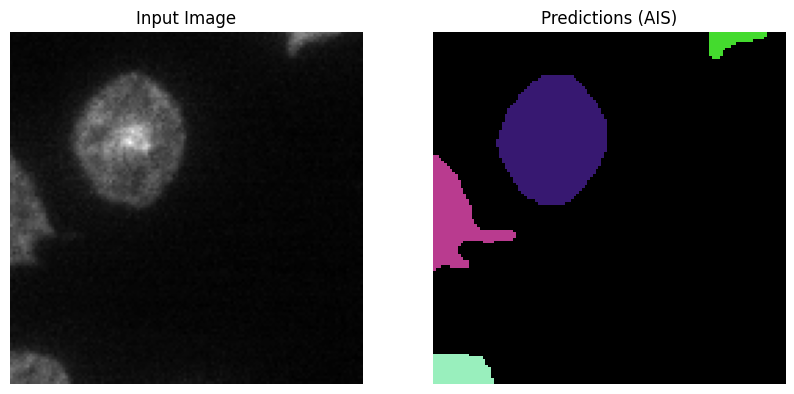

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s]


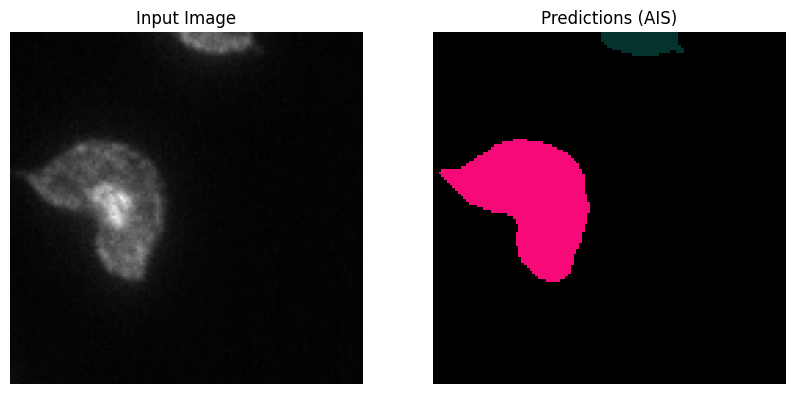

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


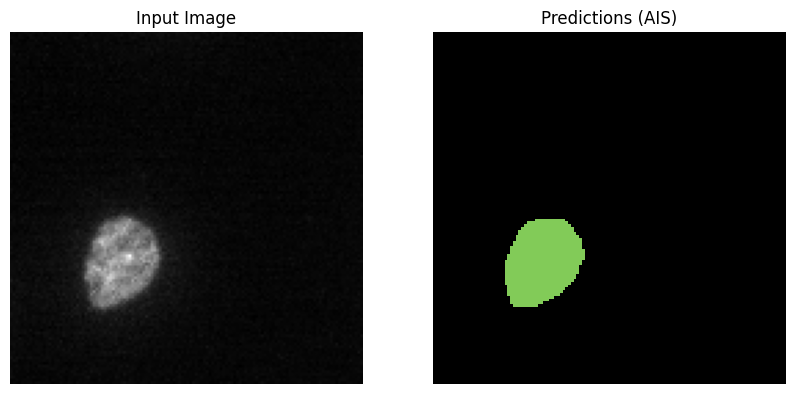

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 30.19it/s]


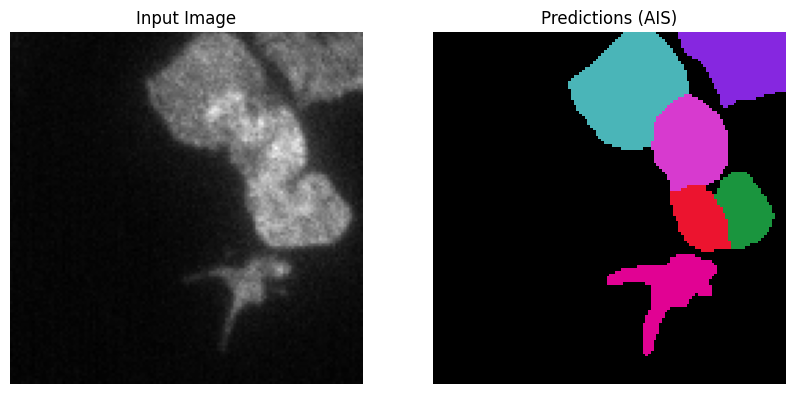

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.11it/s]


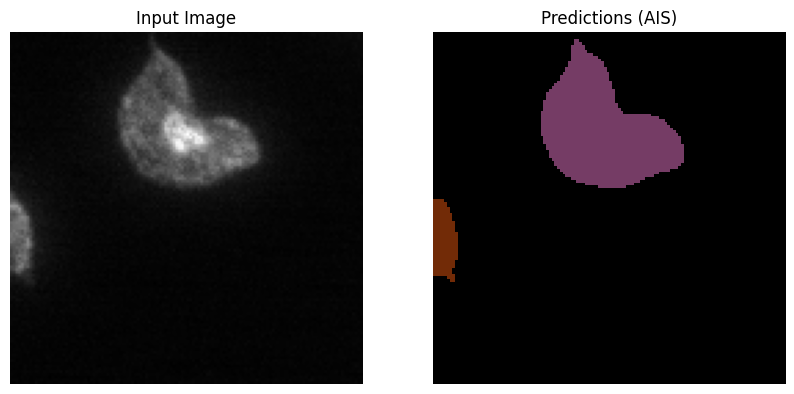

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s]


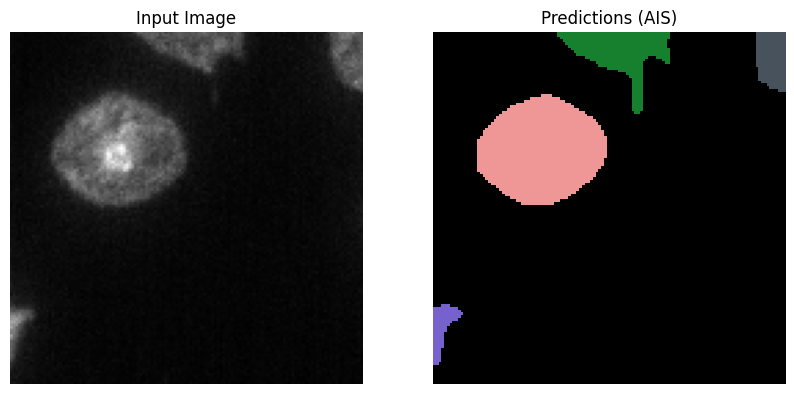

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.00it/s]


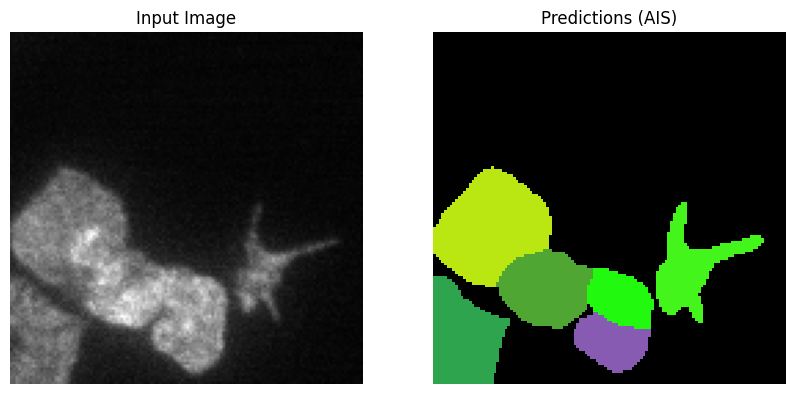

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 30.38it/s]


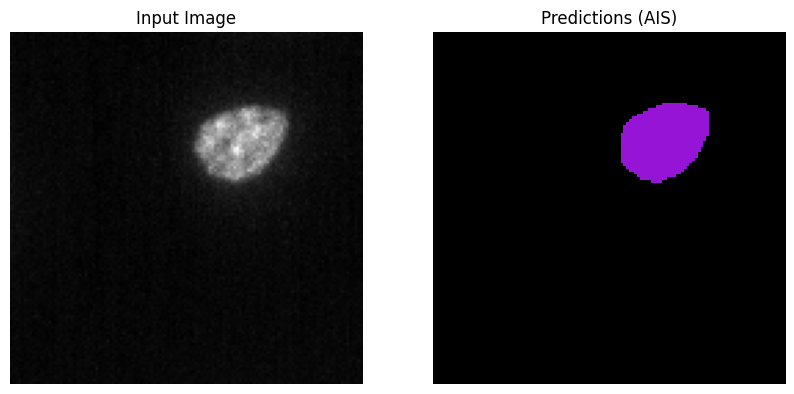

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 30.22it/s]


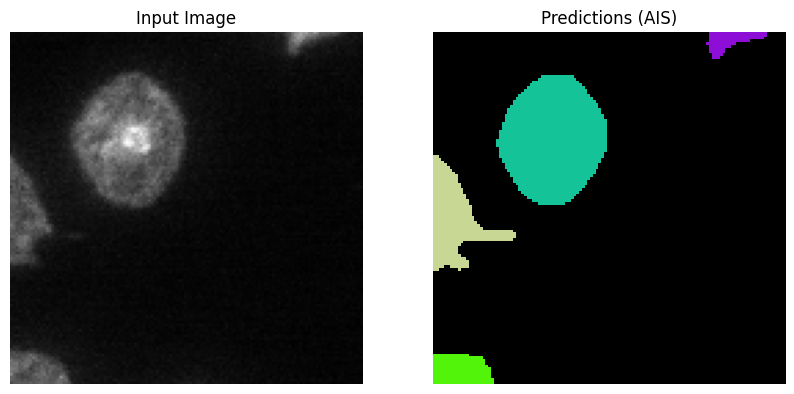

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.99it/s]


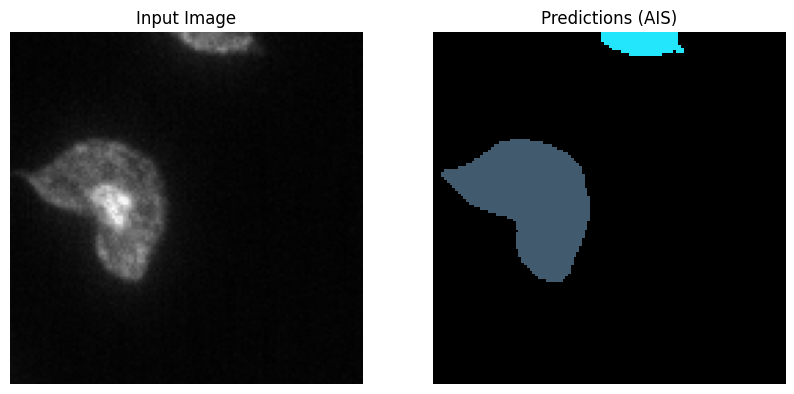

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.91it/s]


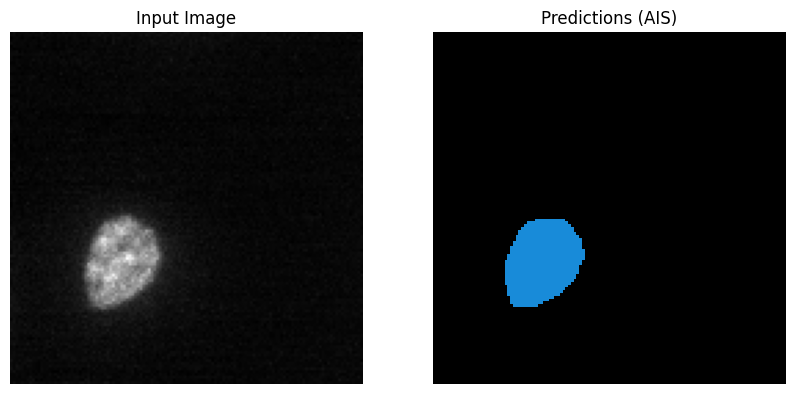

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


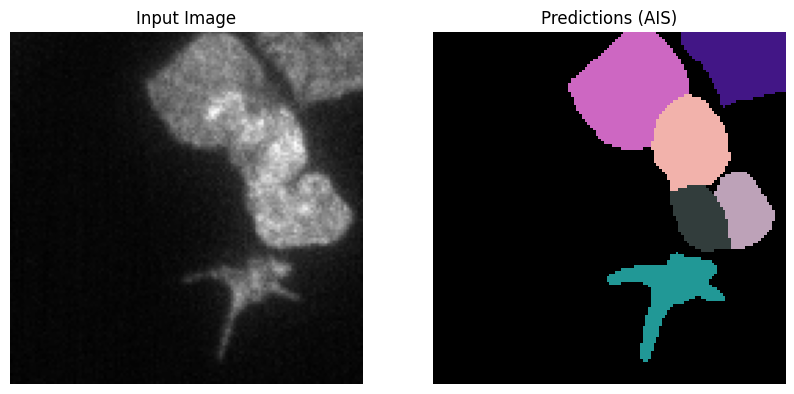

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.00it/s]


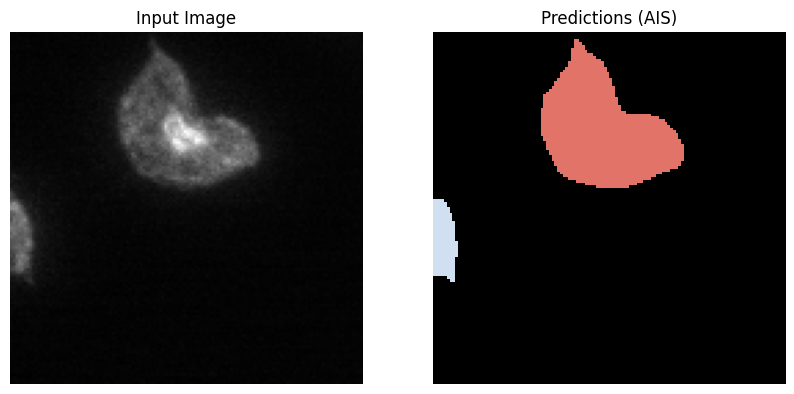

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 29.86it/s]


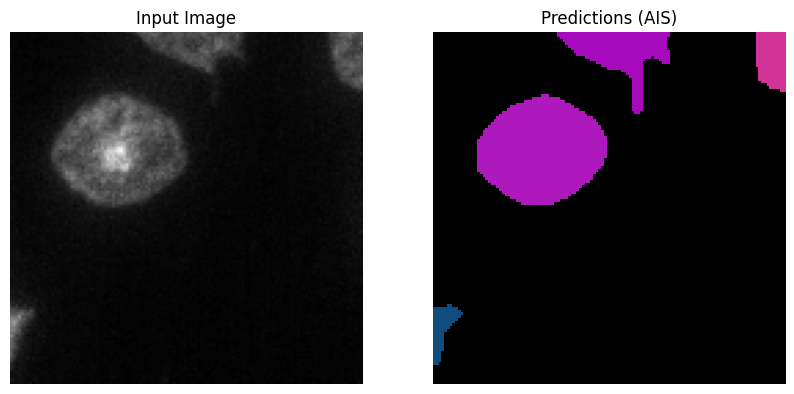

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 31.47it/s]


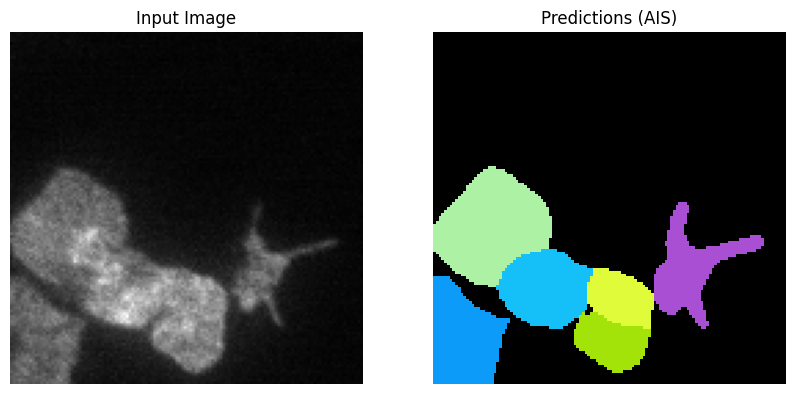

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 30.31it/s]


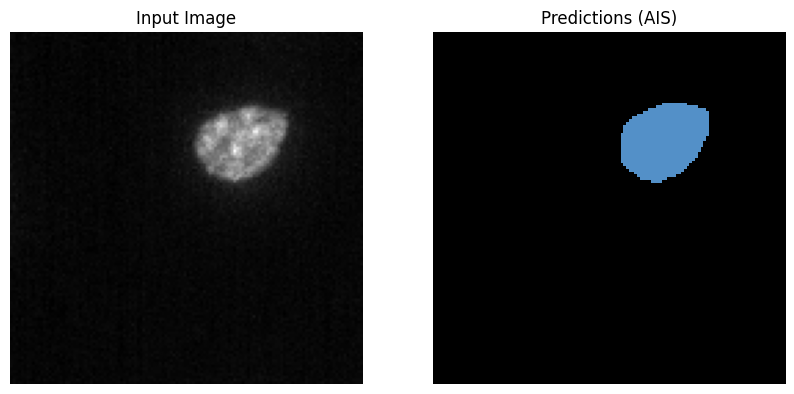

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s]


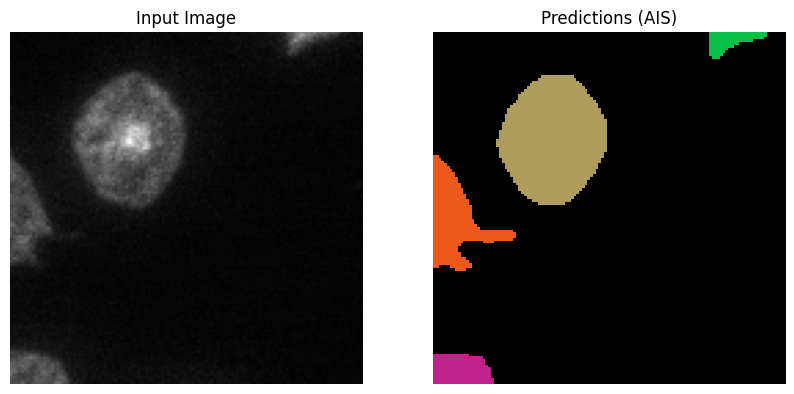

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s]


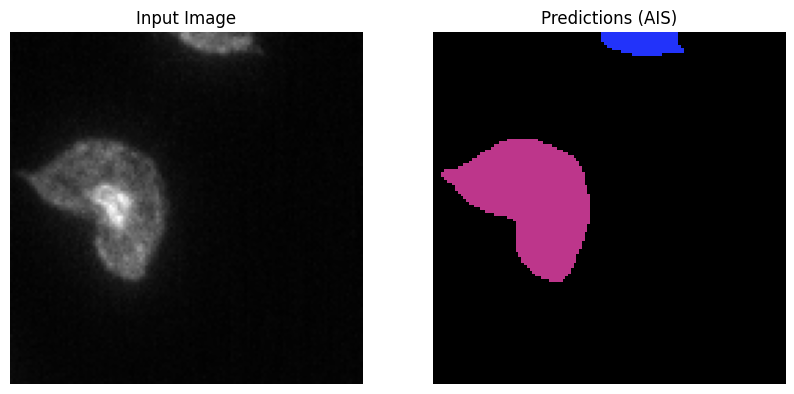

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.84it/s]


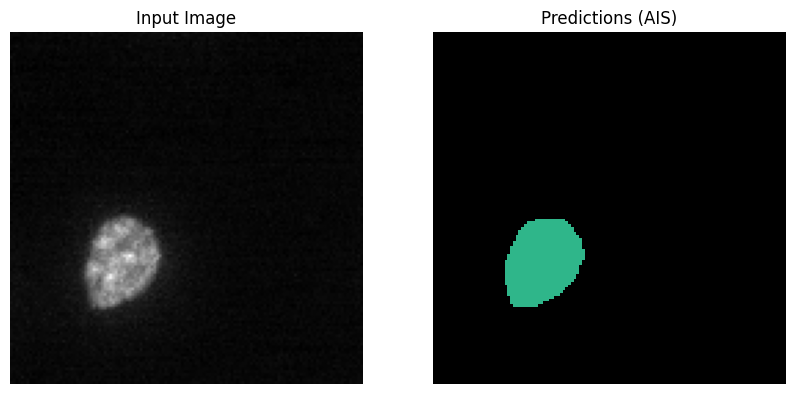

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.48it/s]


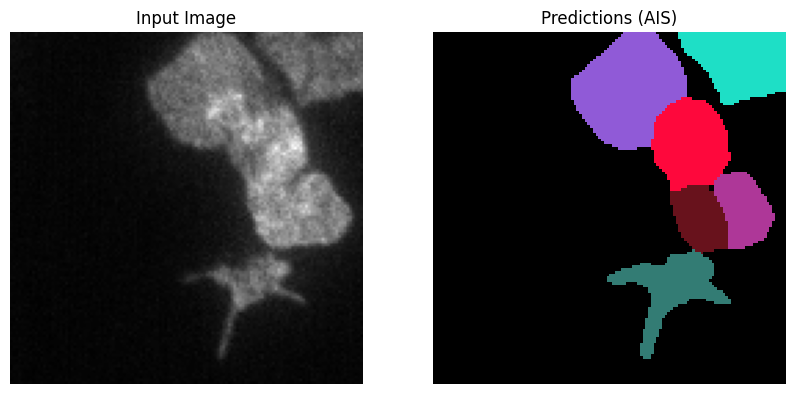

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s]


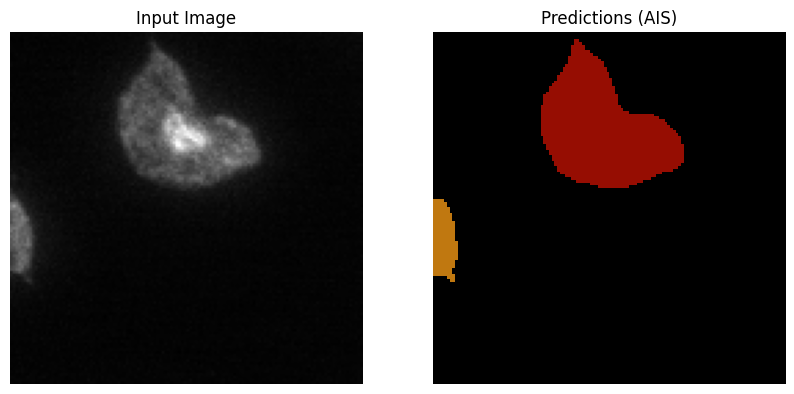

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.30it/s]


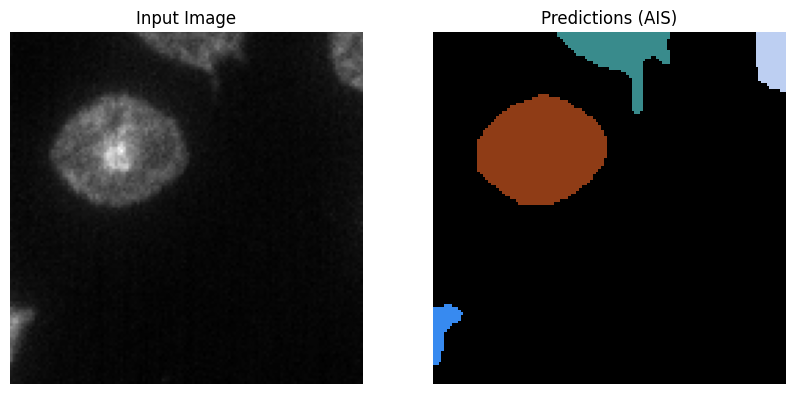

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]


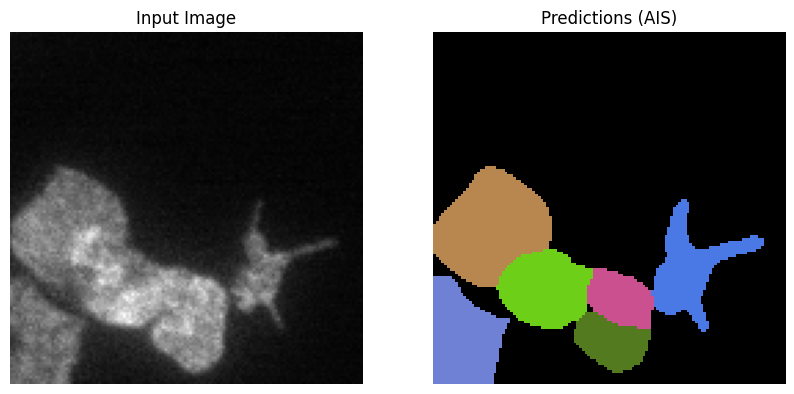

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.88it/s]


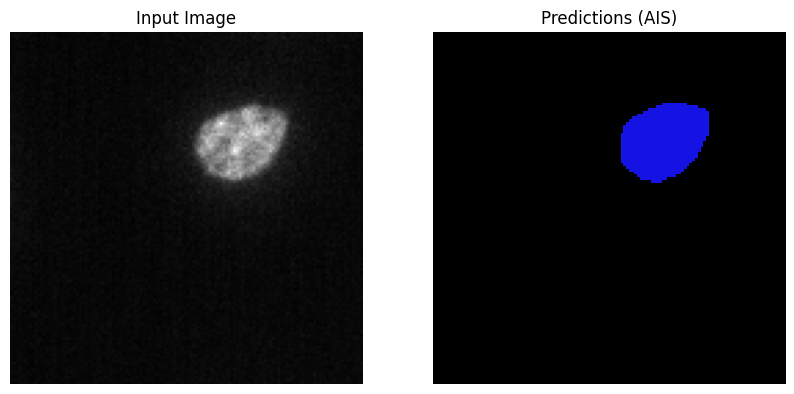

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 31.71it/s]


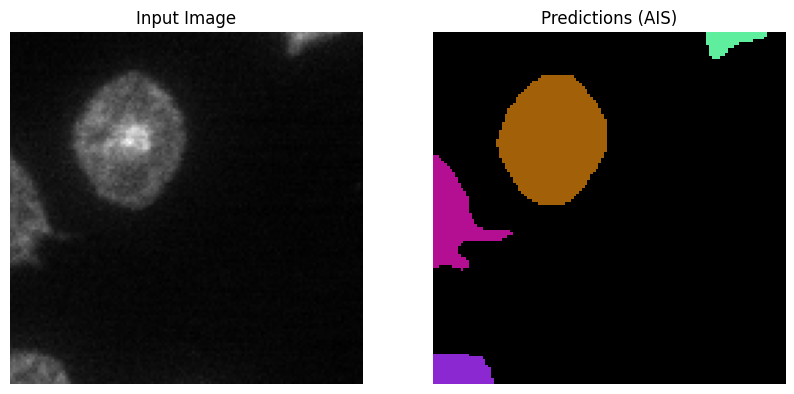

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.90it/s]


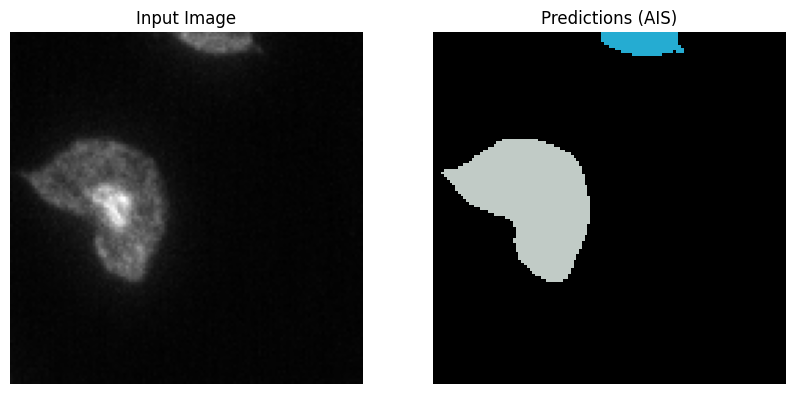

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s]


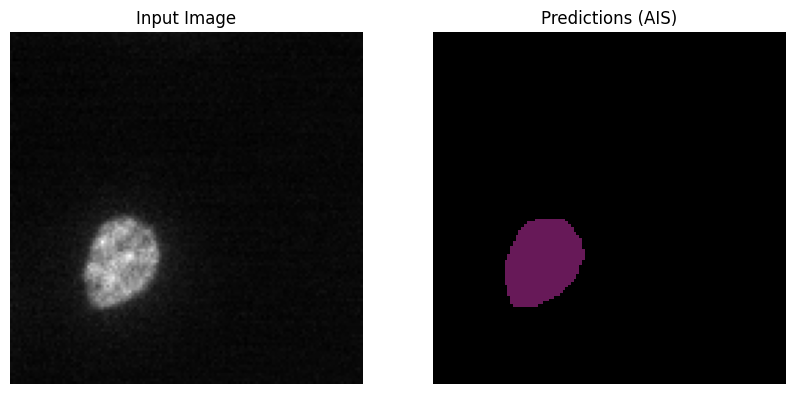

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s]


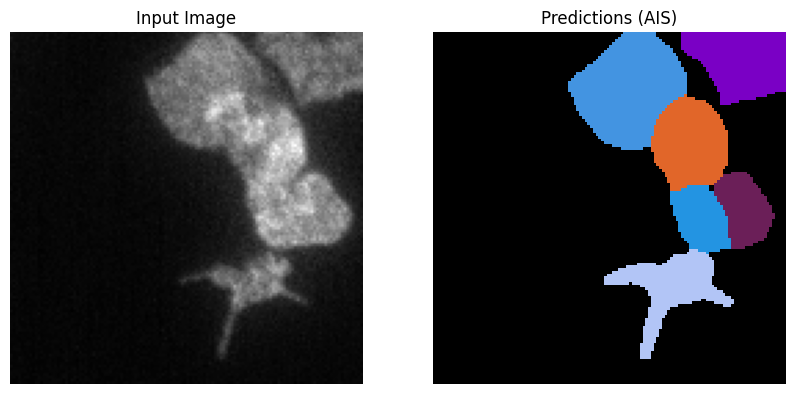

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s]


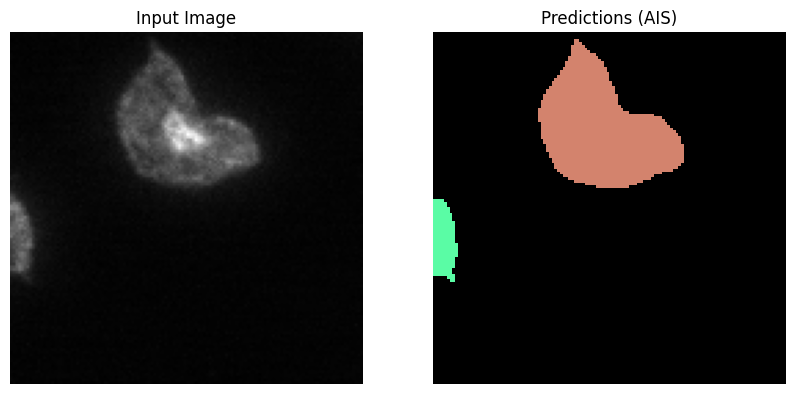

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s]


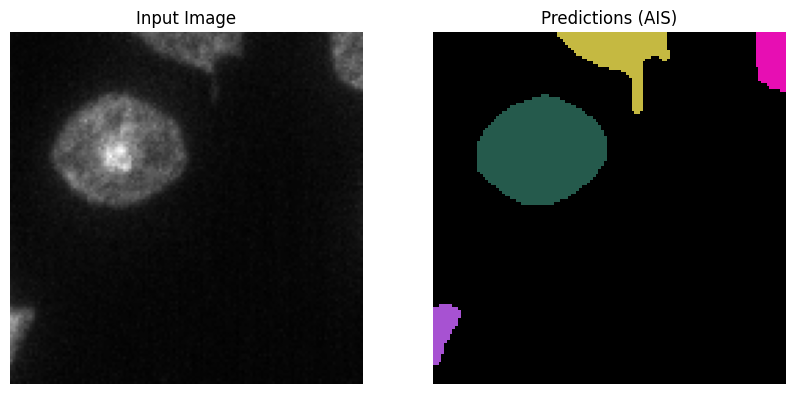

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.15it/s]


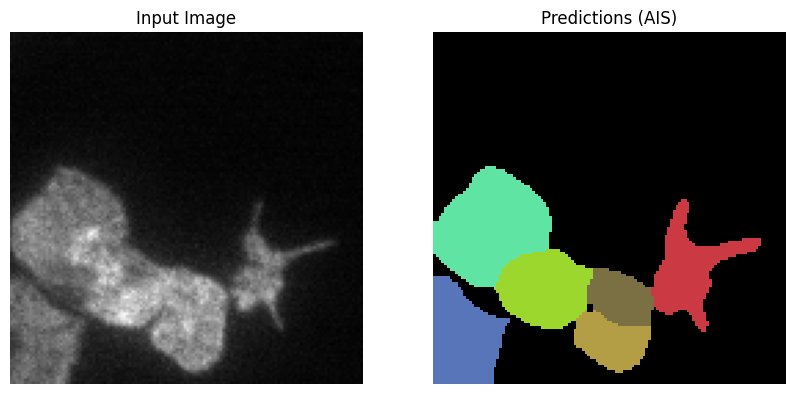

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 30.11it/s]


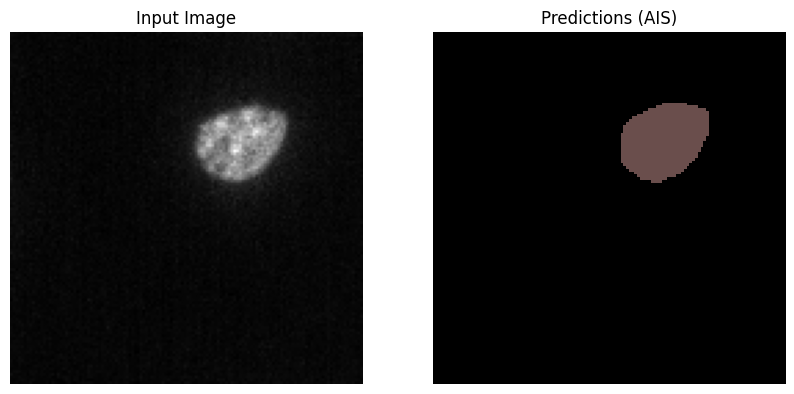

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.64it/s]


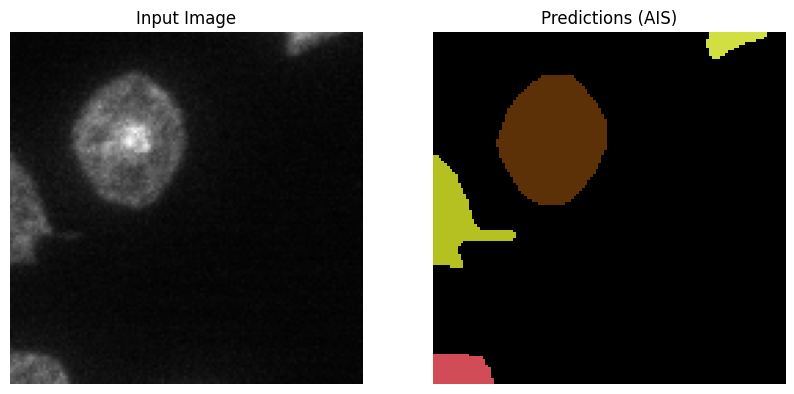

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


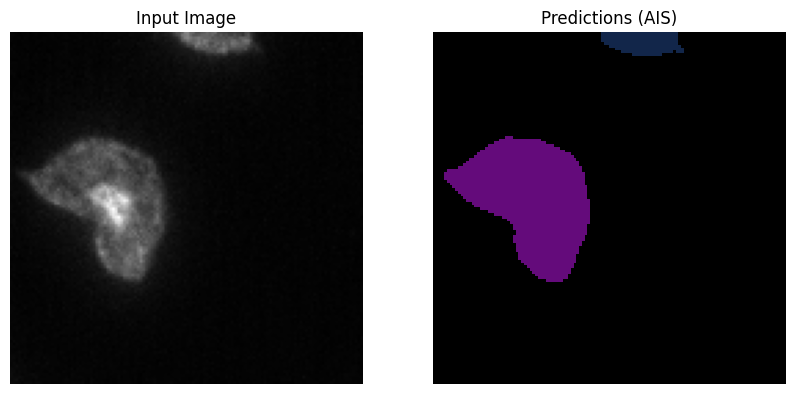

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.17it/s]


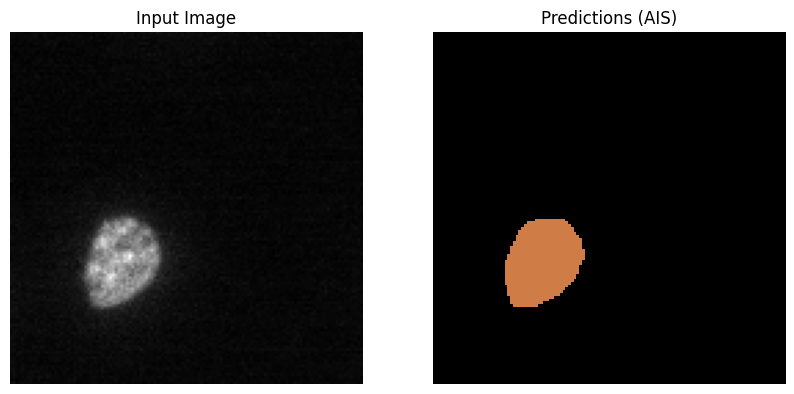

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.58it/s]


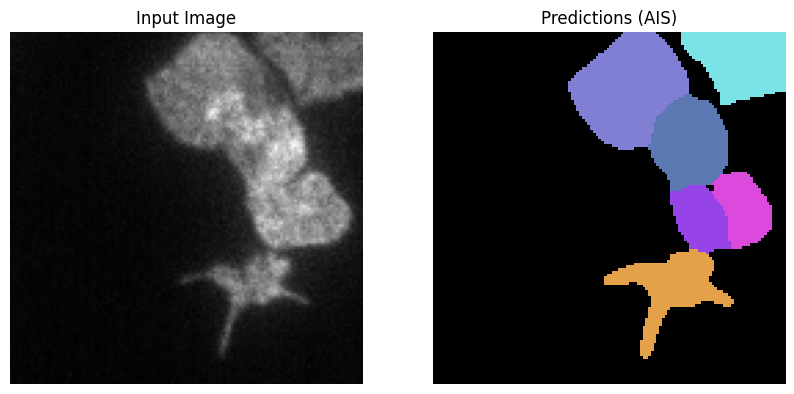

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.70it/s]


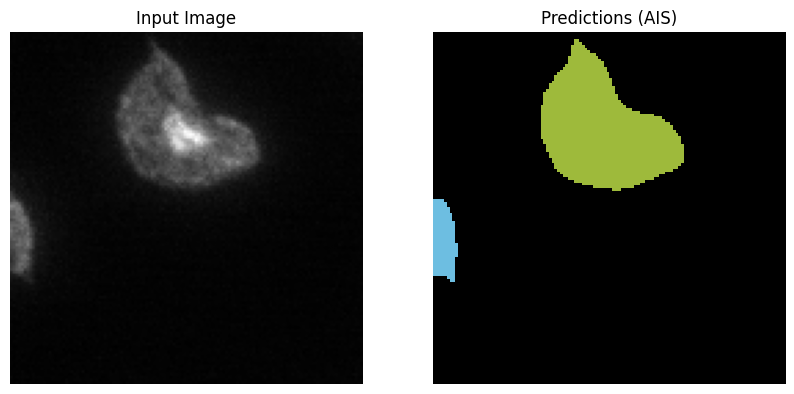

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 29.43it/s]


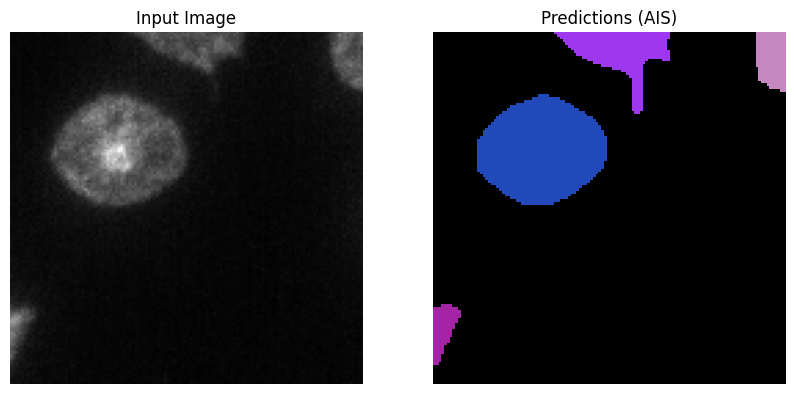

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


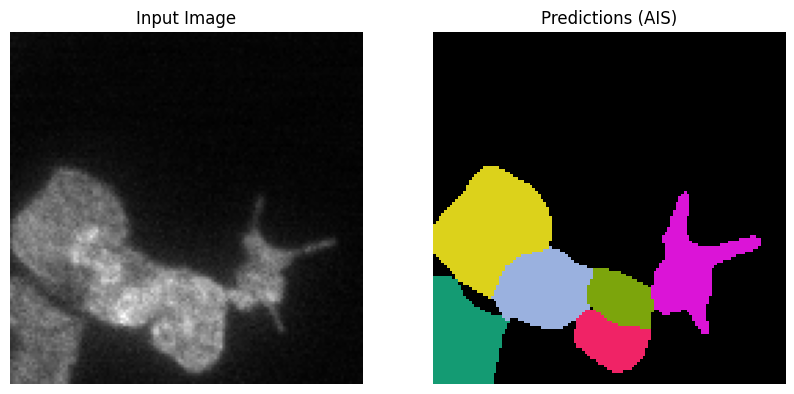

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.04it/s]


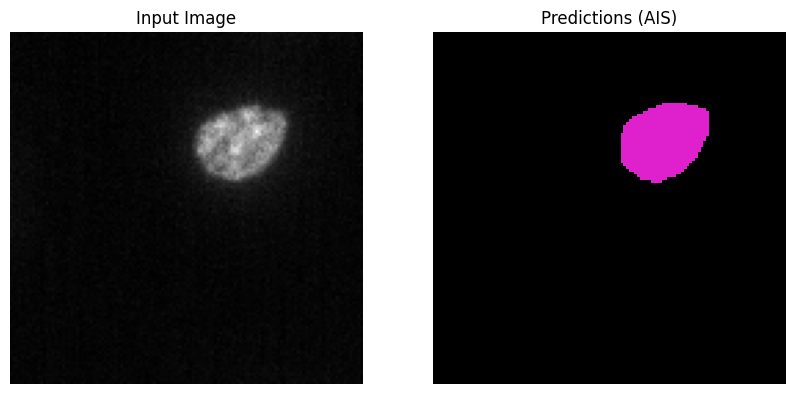

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s]


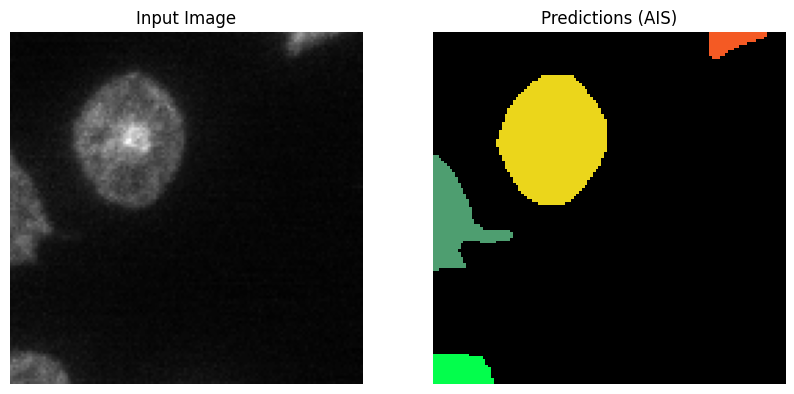

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.20it/s]


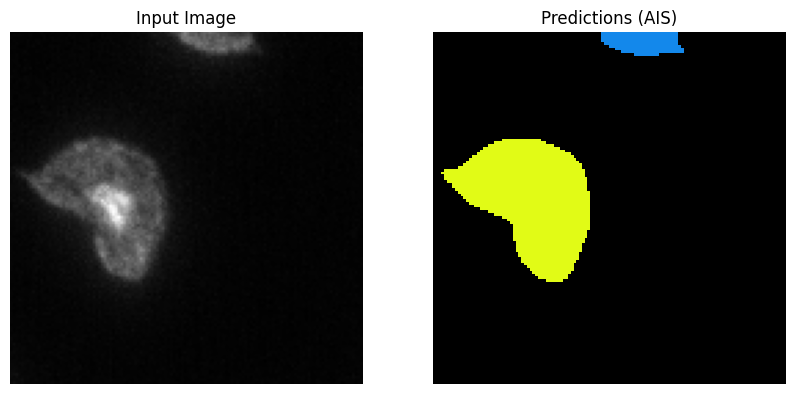

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 28.79it/s]


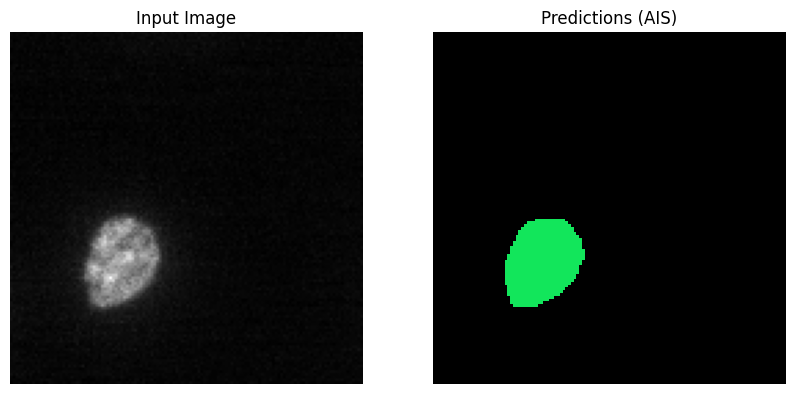

In [ ]:
# %%
ori_tif = 'output.tif'

ori_images = Image.open(ori_tif)
result = []
for i in range(ori_images.n_frames):
    ori_images.seek(i+300)

    this_frame_data = np.array(ori_images)
    this_frame_data = (this_frame_data / this_frame_data.max() * 255).astype(np.uint8)

    prediction = run_automatic_instance_segmentation(
        image=this_frame_data,
        checkpoint_path=best_checkpoint,
        model_type=model_type,
        device=device,
    )
    result.append(prediction)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(this_frame_data, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Input Image")

    ax[1].imshow(prediction, cmap=get_random_colors(prediction), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Predictions (AIS)")

    plt.show()
    plt.close()

In [ ]:
final_result = np.stack(result, axis=0)


In [ ]:
plt.imshow(final_result[100])

In [ ]:
np.savez_compressed('ourdatasets/0_new.npz', final_result)

In [ ]:
# %%
assert os.path.exists(best_checkpoint), "Please train the model first to run inference on the finetuned model."
assert train_instance_segmentation is True, "Oops. You didn't opt for finetuning using the decoder-based automatic instance segmentation."

# Let's check the first 5 images. Feel free to comment out the line below to run inference on all images.
image_paths = image_paths[:5]

for image_path in image_paths:
    image = imageio.imread(image_path)

    # Predicted instances.
    # NOTE: If you have large images, we recommend using tiling for automatic segmentation.
    # eg. for a training patch size of (512, 512), you can provide the following example combination:
    # 'tile_shape=(384, 384). halo=(64, 64)' for running automatic segmentation over tiles.
    prediction = run_automatic_instance_segmentation(
        image=image,
        checkpoint_path=best_checkpoint,
        model_type=model_type,
        device=device,
    )

    # Visualize the predictions
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Input Image")

    ax[1].imshow(prediction, cmap=get_random_colors(prediction), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Predictions (AIS)")

    plt.show()
    plt.close()